<a href="https://colab.research.google.com/github/VinayakMaharaj/STA365-Final-Project/blob/main/Video_Notebook_JM_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hot Hand "Fallacy" - A Bayesian Approach**

---



# **1. Introduction**

The hot hand fallacy is the belief that a person experiencing a successful outcome has a greater chance of success in subsequent attempts. In basketball, the hot hand fallacy is the belief that a player making consecutive shots in a row is speculated to have a non-trivial increase in their chance of making a shot.

Dataset is a log of shot attempts made by the top 15 NBA players in the 2014-15 season who made the most "hot-hand shots".

Our project defines "hot-hand shot" as any shot made by a player after the player has made their last 3 consecutive shots.

# **2. Data Cleaning**

Should include explanation of how we got from kaggle dataset to the important csv file (so extra variables we found and included)

In [1]:
import random
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pymc as pm
import arviz as az
from pymc.math import invlogit as tt_invlogit

df = pd.read_csv('/content/hhs_filter.csv')

In [2]:
#### HELPER FUNCTIONS

def clean_data(df):
    """
    getting rid of unnecessary variables, replacing
    character values with integers,
    nothing too important for presentation purposes
    """
    # need to remove some variables we dont need for the analysis, we helpful
    # when creating the dataset
    df2 = df.iloc[:, 1:]

    df3 = df2.drop(columns= ["GAME_ID", "GAME_CLOCK","SHOT_STREAK", "GAME_HALF",
                            "player_id", "GAME_SHOTS_TAKEN",
                            "SHOT_RESULT", "REFORMATED_DEF_NAME",
                            "CLOSEST_DEFENDER_PLAYER_ID", "SEASON_SHOTS_TAKEN"])

    #remove any rows that have some kind of error we have flagged that
    # cannot be find with generative modeling
    df3 = df3[df3.EXCLUDE == 0]

    #no longer need exclude and fgm column
    clean = df3.drop(columns= ["EXCLUDE"])

    # replace 'A' with '0'
    clean['LOCATION'].replace('A', 0, inplace=True)
    # replace 'A' with '0'
    clean['LOCATION'].replace('H', 1, inplace=True)
    # when shot clock is NaN, we will replace shot clock with game clock value
    clean.loc[df['SHOT_CLOCK'].isnull(),'SHOT_CLOCK'] = df['GAME_CLOCK_DECIMAL']
    return clean


def get_sample_indices(df, amount):
    """ given dataframe return sample indices with <amount> of hhs and non_hhs
    shots from each player"""

    ind_dict = {}
    i = -1
    for index, row in df.iterrows():
        # DO NOT USE THE INDEX VARIABLE ITS GARBAGE AND WRONG
        i += 1
        player = row['player_name']
        if player not in ind_dict:
            ind_dict[player] = {'hhs': [], 'not_hhs': []}
        if row['HOT_HAND_SHOT_STREAK3']:
            ind_dict[player]['hhs'].append(i)
        else:
            ind_dict[player]['not_hhs'].append(i)

    sample_inds = []
    for player in ind_dict:
        sample_inds.extend(random.sample(ind_dict[player]['hhs'], amount))
        sample_inds.extend(random.sample(ind_dict[player]['not_hhs'], amount))

    return sample_inds


def predictor_matrix(data: pd.DataFrame, col_names: list,
                     adjust_std=False) -> np.array:
    """
    given a dataframe  and list  containing p column names,
    return a numpy (N x p+1) matrix X with N observations and p
    standardized predictors (first column is the intercept column full of ones)
    if adjust_std == True, then use n-1 as divisor for std rather than n when
    standardizing predictors
    """
    predictors = data[col_names].to_numpy()
    means = np.mean(predictors, axis=0, keepdims=True)
    deviations = np.std(predictors, axis=0, keepdims=True, ddof=adjust_std)
    normd_predictors = (predictors - means) / deviations
    return np.insert(normd_predictors, 0, 1, axis=1)

In [3]:
np.random.seed(23)

clean = clean_data(df)
N = 750
# N = 250  num of samples to make code run faster
# removes noise and focuses the inference and justification for smaller dataset

# ENSURE N % num_players == 0
num_players = 15
sample_amount = int(N / num_players)
samp = clean.iloc[get_sample_indices(clean, sample_amount)]
samp = samp.drop(columns=["player_name"])

# **3. Exploratory Data Analysis**

In [4]:
print(samp.head(n=5))

     LOCATION  SHOT_NUMBER  PERIOD  GAME_CLOCK_DECIMAL  SHOT_CLOCK  DRIBBLES  \
398         0            8       2            2.516667        20.0         5   
901         1            6       1            3.883333        15.4        12   
809         0           17       3            0.916667        18.7         3   
638         1           14       4            0.950000         8.6        13   
320         1            5       1            3.083333        11.0        12   

     SHOT_DIST  PTS_TYPE  DEFENDER_HEIGHT_CM  DEFENDER_WEIGHT_KG  \
398       26.2         3              198.12            86.18248   
901       11.6         2              210.82           120.20188   
809       25.5         3              187.96            86.18248   
638       27.9         3              208.28           108.86208   
320       32.2         3              205.74           102.05820   

     CLOSE_DEF_DIST  FGM  PLAYER_HEIGHT  PLAYER_WEIGHT  HOT_HAND_SHOT_STREAK2  \
398             4.3    0     

In [25]:
# design matrix 1
# list of column names you want to keep to use as predictors:
col_names1 = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_DECIMAL',
            'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
             'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
             'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']
X1 = predictor_matrix(samp, col_names1)
P1 = X1.shape[1] - 1

#Look into colinearity, and exclude some with high colinearity

In [26]:
# design matrix 2, removed some predictors with high multicolinearity or were variables we felt were not nessesary (found below)

col_names2 = ['LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']
X2 = predictor_matrix(samp, col_names2)
P2 = X2.shape[1] - 1
P2


7

Location and Hot hand shot streak is a binary value

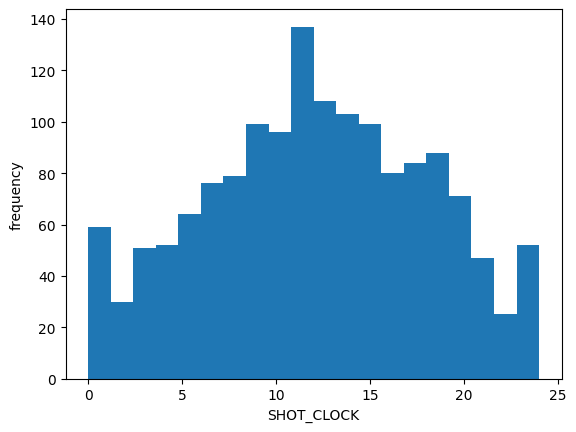

In [7]:
plt.hist(samp['SHOT_CLOCK'],bins=20)
plt.xlabel('SHOT_CLOCK')
plt.ylabel('frequency')
plt.show()

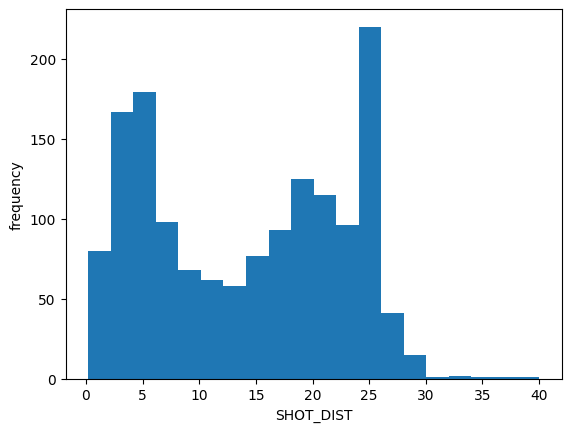

In [8]:
plt.hist(samp['SHOT_DIST'],bins=20)
plt.xlabel('SHOT_DIST')
plt.ylabel('frequency')
plt.show()

Largely Bimodal do to the nature of how NBA teams prefer to take shot, most teams like to either take close layups or 3 point shots as they have been proven to be the most efficient shots.

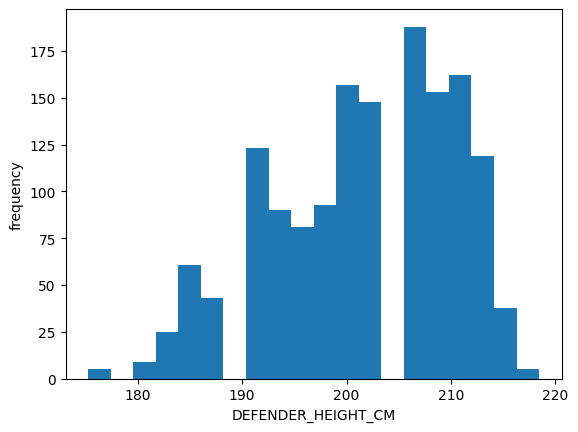

In [9]:
plt.hist(samp['DEFENDER_HEIGHT_CM'],bins=20)
plt.xlabel('DEFENDER_HEIGHT_CM')
plt.ylabel('frequency')
plt.show()

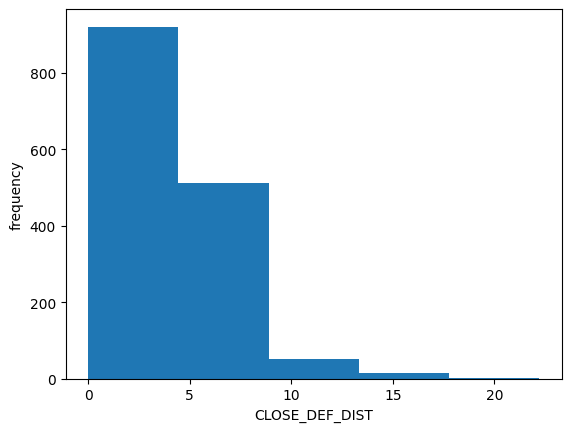

In [10]:
plt.hist(samp['CLOSE_DEF_DIST'],bins=5)
plt.xlabel('CLOSE_DEF_DIST')
plt.ylabel('frequency')
plt.show()

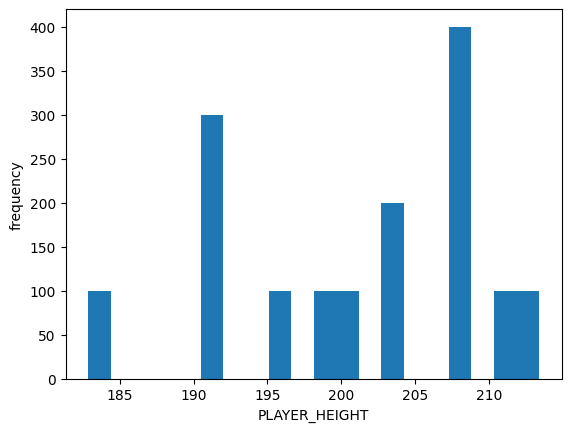

In [11]:
plt.hist(samp['PLAYER_HEIGHT'],bins=20)
plt.xlabel('PLAYER_HEIGHT')
plt.ylabel('frequency')
plt.show()

For most of the variables a Normal distribution would be justified to be used as a prior, some could potentially use a bernoulli dist or bimodal dists could use a mixture dist.

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.DataFrame(X1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['FGM','LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_DECIMAL',
            'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
             'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
             'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

#anything above 5 is high multicolinearity

                  feature       VIF
0                     FGM  1.000000
1                LOCATION  1.011356
2             SHOT_NUMBER  3.805586
3                  PERIOD  3.518337
4      GAME_CLOCK_DECIMAL  1.379083
5              SHOT_CLOCK  1.160347
6                DRIBBLES  1.475491
7               SHOT_DIST  1.515630
8      DEFENDER_HEIGHT_CM  3.342502
9      DEFENDER_WEIGHT_KG  3.382757
10         CLOSE_DEF_DIST  1.368503
11          PLAYER_HEIGHT  7.801635
12          PLAYER_WEIGHT  6.572102
13  HOT_HAND_SHOT_STREAK3  1.115558


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.DataFrame(X2)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['FGM','LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
               'CLOSE_DEF_DIST', 'PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

#anything above 5 is high multicolinearity, notice how all predictors look to have little multi-colinearity

                 feature       VIF
0                    FGM  1.000000
1               LOCATION  1.005264
2             SHOT_CLOCK  1.074039
3              SHOT_DIST  1.469444
4     DEFENDER_HEIGHT_CM  1.228320
5         CLOSE_DEF_DIST  1.356193
6          PLAYER_HEIGHT  1.233840
7  HOT_HAND_SHOT_STREAK3  1.017222


In [14]:
y2 = np.zeros((2*N,1))
y2[:,0] = samp['FGM']

# **4. Prior Philosophy**

explain idea from paper

# **5. Exploring Different Models**


Only standardize variables after bad performance ? Why would anyone choose to standardize everything without even checking that its needed?

will explore numerous different models (small sample) in this section and attempt to show that these models were considered and evaluated (including assumptions)

in last subsection we compare them

## Model 1

In [15]:
import pymc as pm; import numpy as np
#model 1 (uses design matrix 2), Basic multivariate bayesian regression model
#redefine col names just for naming ease
col_names = ['Intercept', 'LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']

with pm.Model(coords={"cluster": col_names}) as MLR:
    # Define a multivariate normal (MvNormal) distribution for the regression coefficients ('betas').
    # 'mu' specifies the mean of the distribution, set to a zero vector of size P2+1 to indicate no prior bias.
    # 'cov' specifies the covariance matrix, set to an identity matrix of size P2+1, assuming independence and identical variance.
    # 'shape' specifies the shape of the variable, here a vector of size P2+1, where P2 is presumably the number of predictors.
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,)), cov=np.eye(P2+1), shape=(P2+1,), dims = 'cluster')
    # Define a Bernoulli distribution for the dependent variable 'y'.
    # 'logit_p' specifies the logit of the probability of success, calculated as the dot product of predictors 'X2' and coefficients 'betas'.
    # 'observed' is set to 'y2', indicating that 'y' is an observed variable in the data.
    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas), observed = y2)
with MLR:
    idata = pm.sample(random_seed=1999)

# do more analysis / visualizations

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


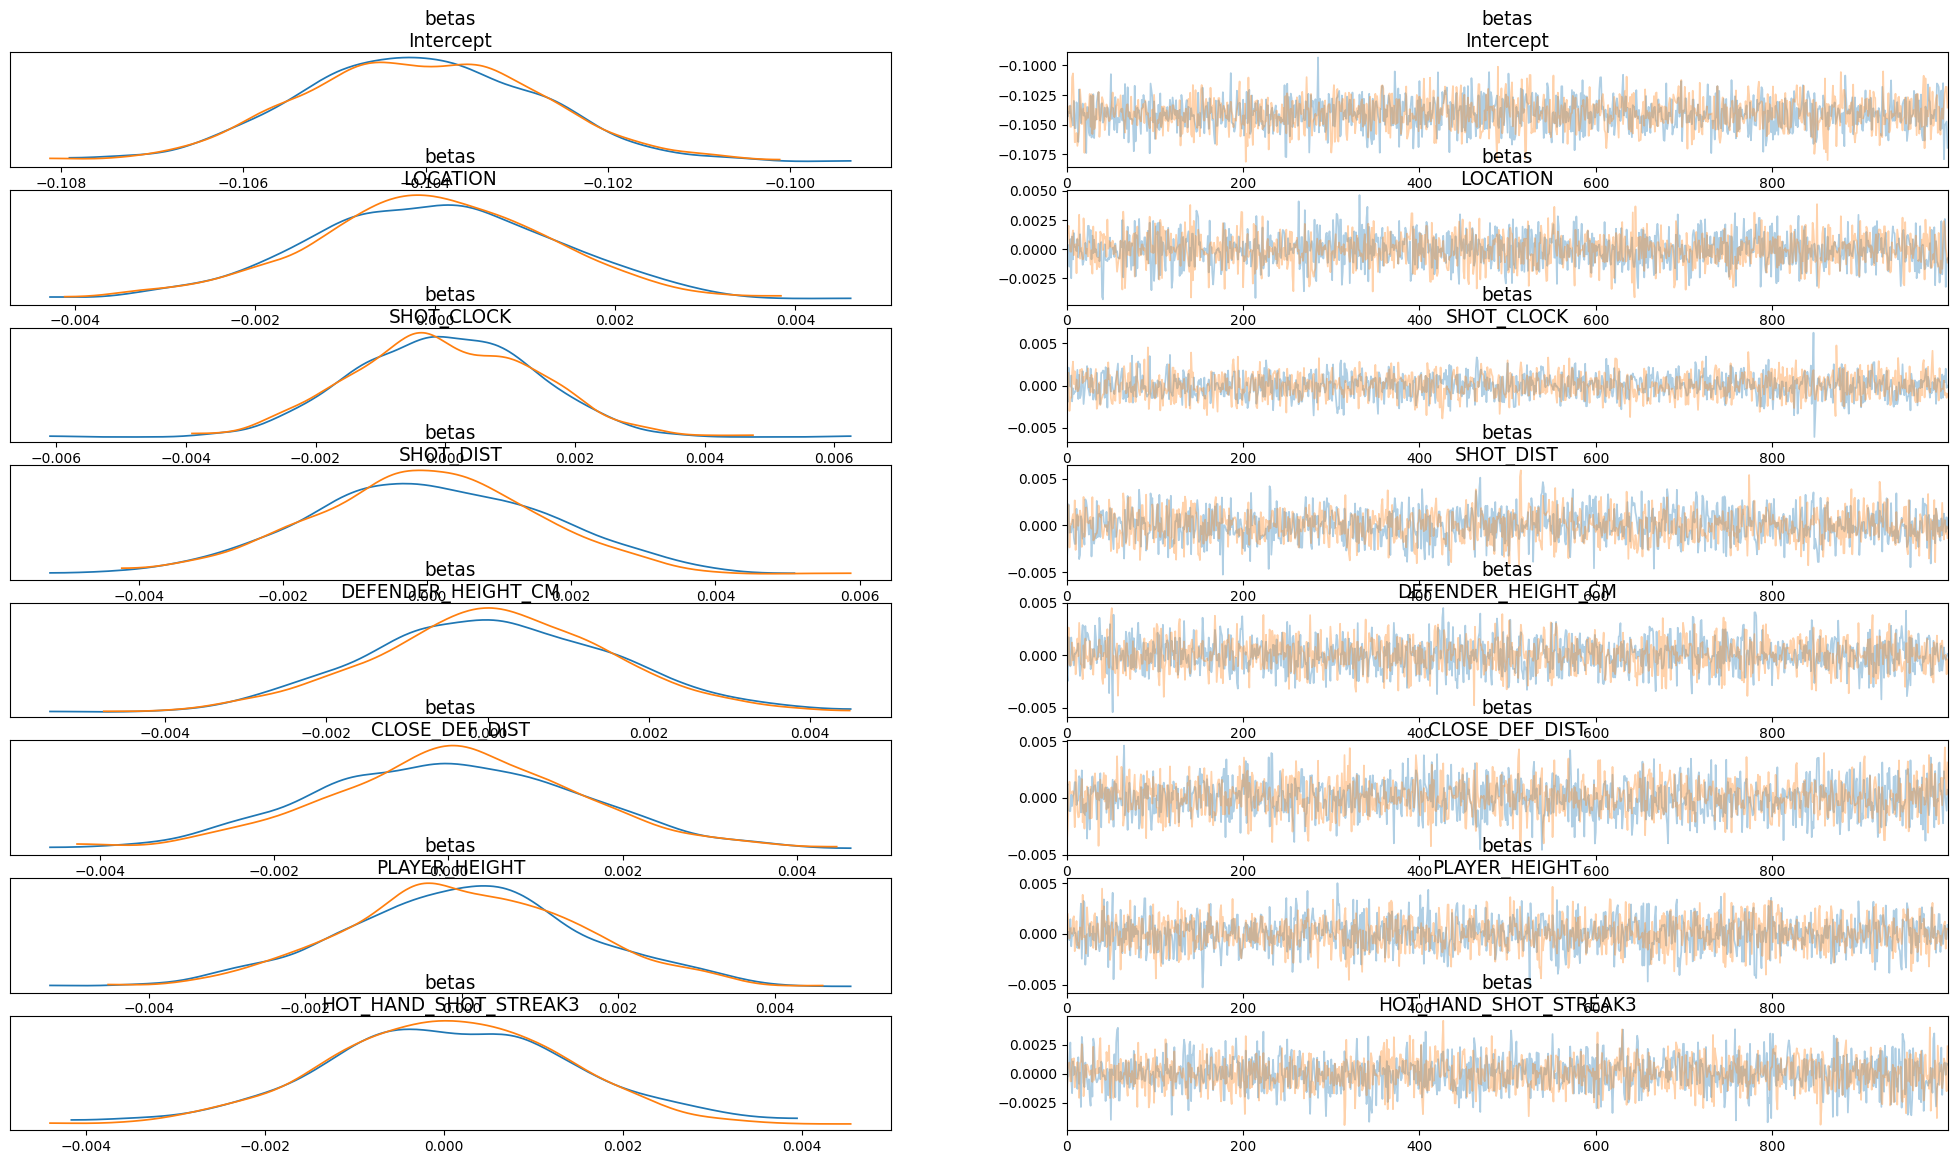

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'betas': array([0.99960902, 1.00035066, 1.00024021, 1.00120636, 1.00115657,
       1.00163017, 0.99955837, 1.00339999])} | 

In [16]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Customizing plot parameters for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Increase the figure size
# Note: compact=False ensures that each variable has two subplots, one for the trace and one for the density
# If the resulting plot still appears squished, consider making the figure size even larger,
# or reducing the number of variables plotted in a single call to plot_trace
az.plot_trace(idata, compact=False, combined=False, figsize=(25, P2*2))  # P2 is the number of parameters

# The layout will be adjusted automatically since we are not using 'ax' anymore
plt.show()

# Print the R-hat statistics
rhat_values = az.rhat(idata)
print("HMC Split-Rhats", {k: np.round(v.values, P2+1) for k, v in rhat_values.items()}, end=' | ')

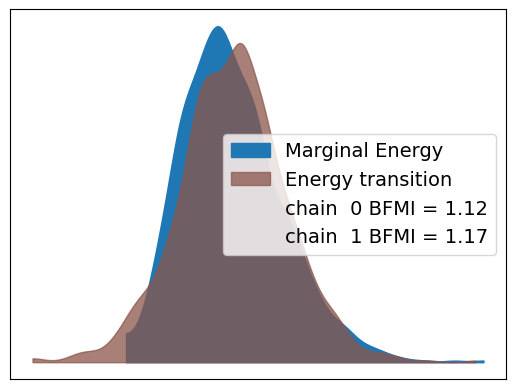

In [17]:
az.plot_energy(idata);

The results of Model 1 show decent convergence with minimal issues such as sticky chains. the rhat value are all less than 1.05, and the energy graph doesnt show concernable issues. This model is very basic but it shows us that a Multivariate Normal prior can be a sufficient prior for the betas even if the data may not all follow a normal dist.

## Model 2

In [18]:

import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit
#model 2, multivariate bayesian heirarchial regression using a horshoe prior and LKJ factor
with pm.Model(coords={"cluster": col_names}) as MLR:
   # Define an LKJ Cholesky covariance matrix, a method for specifying a prior over covariance matrices in a way that
    # is computationally efficient and ensures positive definiteness. It's particularly useful for multivariate normal distributions.
    packed_L = pm.LKJCholeskyCov("packed_L", n= P2+1, eta=2.0, sd_dist=pm.HalfCauchy.dist(beta=10, shape=P2+1), compute_corr=False)
    L = pm.expand_packed_triangular(P2+1, packed_L);
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    # Implement the horseshoe prior for regularization, helping in identifying truly relevant predictors among potentially many covariates.
    tau_0 = 1;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape= 1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=1);
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1))

     # Define the multivariate normal distribution for regression coefficients ('betas'), with a mean vector of zeros
    # and the covariance matrix 'Sigma' determined above.
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,)), cov= Sigma, shape=(P2+1,), dims = 'cluster')

    # Define the observed variable 'y', modeled as a Bernoulli distribution with the logit of the probability
    # determined by the dot product of the predictors 'X2' and the product of 'betas' and 'weights'.
    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas*weights), observed = y2)

    #set up and perform sampling using the Metropolis-Hastings algorithm, a specific MCMC method.
with MLR:
    MH = pm.Metropolis([betas], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH,random_seed=1999)

    #for proj we can make note on how long it takes computationally to use chol
    #problem in mixing?
    #invalid value could be near 0 value in log

ValueError: Not enough samples to build a trace.

Code takes too long to run, ideally would be able to see what the results would be with the code below. would like to include LKJ factors into later models but clear that this would make the code take too long

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata_MH,compact=False, combined = False);
print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata_MH).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Customizing plot parameters for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Increase the figure size
# Note: compact=False ensures that each variable has two subplots, one for the trace and one for the density
# If the resulting plot still appears squished, consider making the figure size even larger,
# or reducing the number of variables plotted in a single call to plot_trace
az.plot_trace(idata_MH, compact=False, combined=False, figsize=(25, P2*2))  # P2 is the number of parameters

# The layout will be adjusted automatically since we are not using 'ax' anymore
plt.show()

# Print the R-hat statistics
rhat_values = az.rhat(idata_MH)
print("HMC Split-Rhats", {k: np.round(v.values, P2+1) for k, v in rhat_values.items()}, end=' | ')


In [ ]:
az.plot_energy(idata_MH);

## Model 3

In [28]:
import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit

#model 3, bayesian multivariate regression model with horseshoe prior
with pm.Model(coords={"cluster": col_names}) as MLR:

    # Set up the horseshoe prior for regularization, aiming to identify significant predictors.
    # The horseshoe prior is a robust regularization method that can effectively handle cases with many predictors,
    # distinguishing between relevant and irrelevant ones by shrinking the latter towards zero.
    tau_0 = 0.75;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=1);
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1))
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,)), cov= np.eye(P2+1), shape=(P2+1,), dims = 'cluster')

     # Define the likelihood of the observed data 'y', assuming a Bernoulli distribution.
    # The logit of the success probability is given by the dot product of predictors 'X2' and the product of 'betas' and 'weights'.
    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas*weights), observed = y2)
with MLR:
    idata = pm.sample(random_seed=1999)



ValueError: Not enough samples to build a trace.

The idea of a horshoe prior on the betas we believe will work and has worked on previous model iteration when the data was different. we will try adding more priors to the data such as spike-slab to see if that helps the model

## Model 4

In [20]:
#model 4, multivariate bayesian regression with standard normal prior on all predictors other than hot-hand, hot hand has a spike slab with standard normal prior
P2 = X2.shape[1]

col_names = ['Intercept', 'LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT']
with pm.Model(coords={"cluster": col_names}) as MLR:
    # Spike-Slab components for the HOT_HAND_SHOT_STREAK3 coefficient
    inclusion_prob = pm.Beta('inclusion_prob', alpha=1, beta=1)
    slab = pm.Normal('slab', mu=0, sigma=1)

    # Binary variable to choose between spike (effect = 0) and slab
    include_effect = pm.Bernoulli('include_effect', p=inclusion_prob)

    # Coefficient for HOT_HAND_SHOT_STREAK3
    # beta_hot_hand = pm.math.switch(include_effect, slab, 0)
    beta_hot_hand = pm.Deterministic("beta_hot_hand", include_effect*slab)

    # Coefficients for other predictors
    #betas_other = pm.Normal('betas_other', mu=0, sigma=1, shape=(P2-1,), dims = 'cluster')
    betas_other = pm.MvNormal('betas_other', mu= np.zeros((P2-1,)), cov= np.eye(P2-1), shape=(P2-1,), dims = 'cluster')

    # Combine all coefficients, assuming HOT_HAND_SHOT_STREAK3 is the last predictor in X2
    # Adjust the concatenation logic if HOT_HAND_SHOT_STREAK3 is in a different position
    betas = pm.math.concatenate([betas_other, [beta_hot_hand]])

    # Calculate the probability of a shot being made
    p_shot_made = pm.math.sigmoid(pm.math.dot(X2, betas))

    # Likelihood of observing the data
    y = pm.Bernoulli('y', p=p_shot_made, observed=y2.flatten())
with MLR:
    idata = pm.sample(random_seed=1999)


HMC Split-Rhats {'slab': 1.006057458, 'include_effect': 1.017775084, 'betas_other': array([1.00243778, 1.00317797, 1.00147929, 1.00244924, 1.00256863,
       1.00102899, 1.00739452]), 'inclusion_prob': 1.009740604, 'beta_hot_hand': 1.01834882} | 

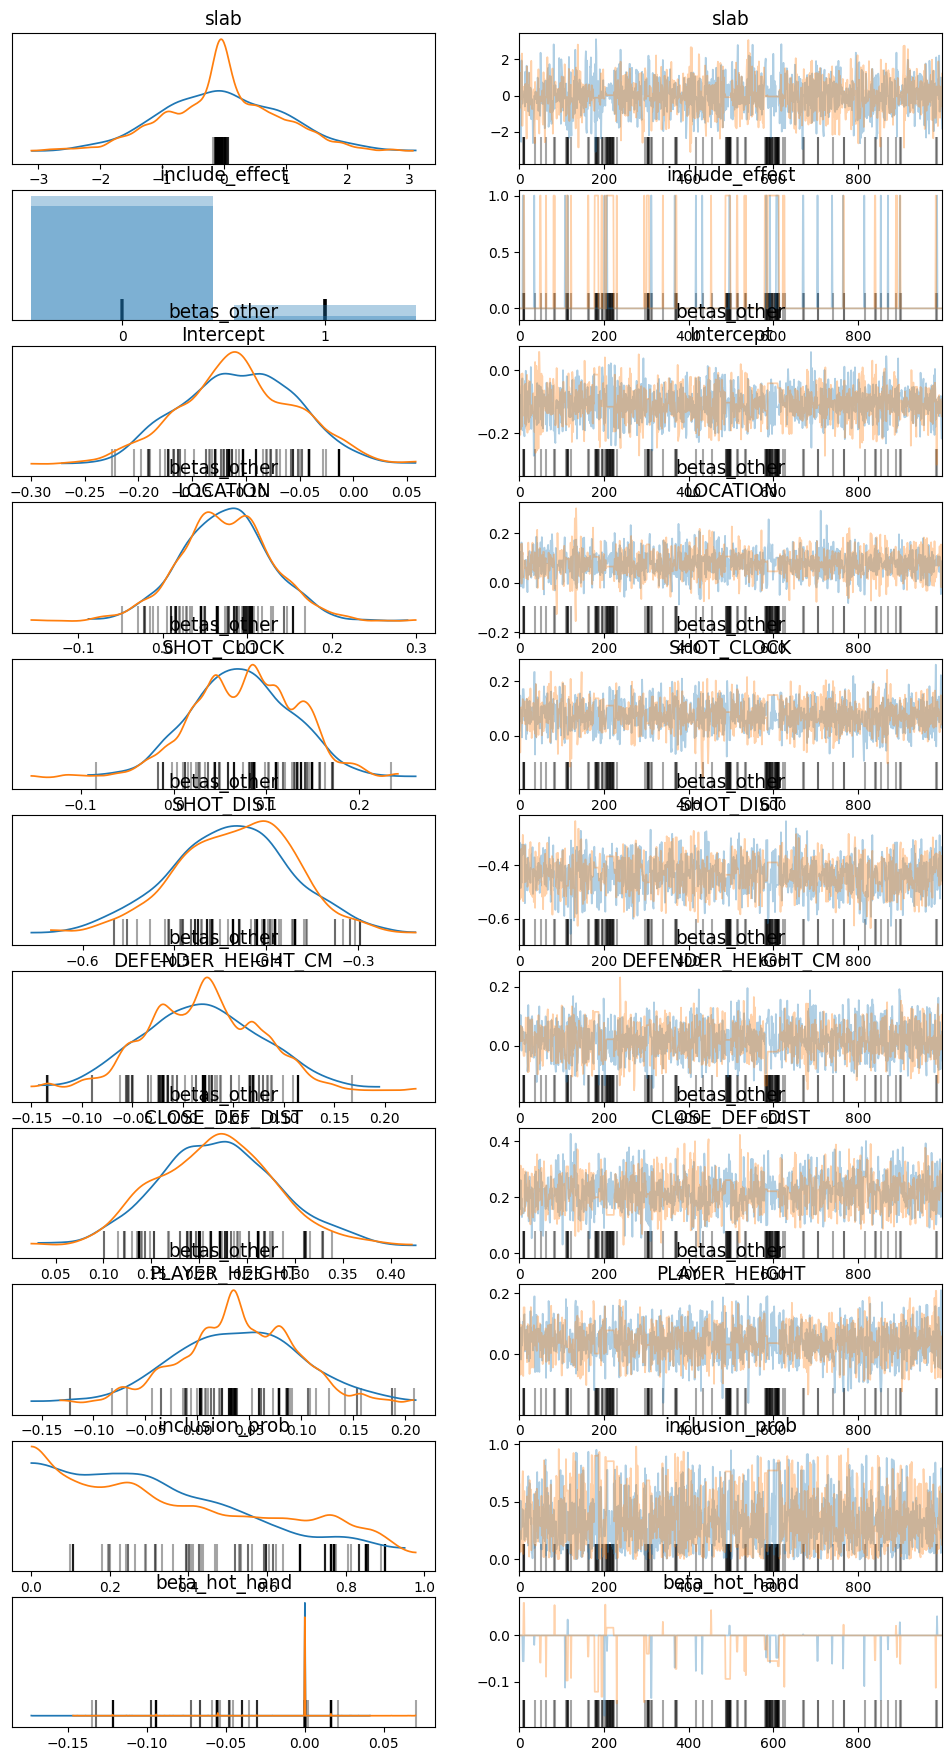

                                  mean     sd  hdi_3%  hdi_97%  mcse_mean  \
slab                            -0.027  0.981  -1.851    1.885      0.018   
include_effect                   0.074  0.262   0.000    1.000      0.022   
betas_other[Intercept]          -0.107  0.054  -0.205   -0.006      0.001   
betas_other[LOCATION]            0.075  0.054  -0.030    0.171      0.001   
betas_other[SHOT_CLOCK]          0.075  0.055  -0.028    0.171      0.002   
betas_other[SHOT_DIST]          -0.436  0.065  -0.555   -0.306      0.002   
betas_other[DEFENDER_HEIGHT_CM]  0.019  0.058  -0.093    0.121      0.001   
betas_other[CLOSE_DEF_DIST]      0.218  0.063   0.104    0.337      0.002   
betas_other[PLAYER_HEIGHT]       0.039  0.058  -0.076    0.142      0.001   
inclusion_prob                   0.351  0.249   0.000    0.799      0.010   
beta_hot_hand                   -0.004  0.019  -0.000    0.041      0.001   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
slab 

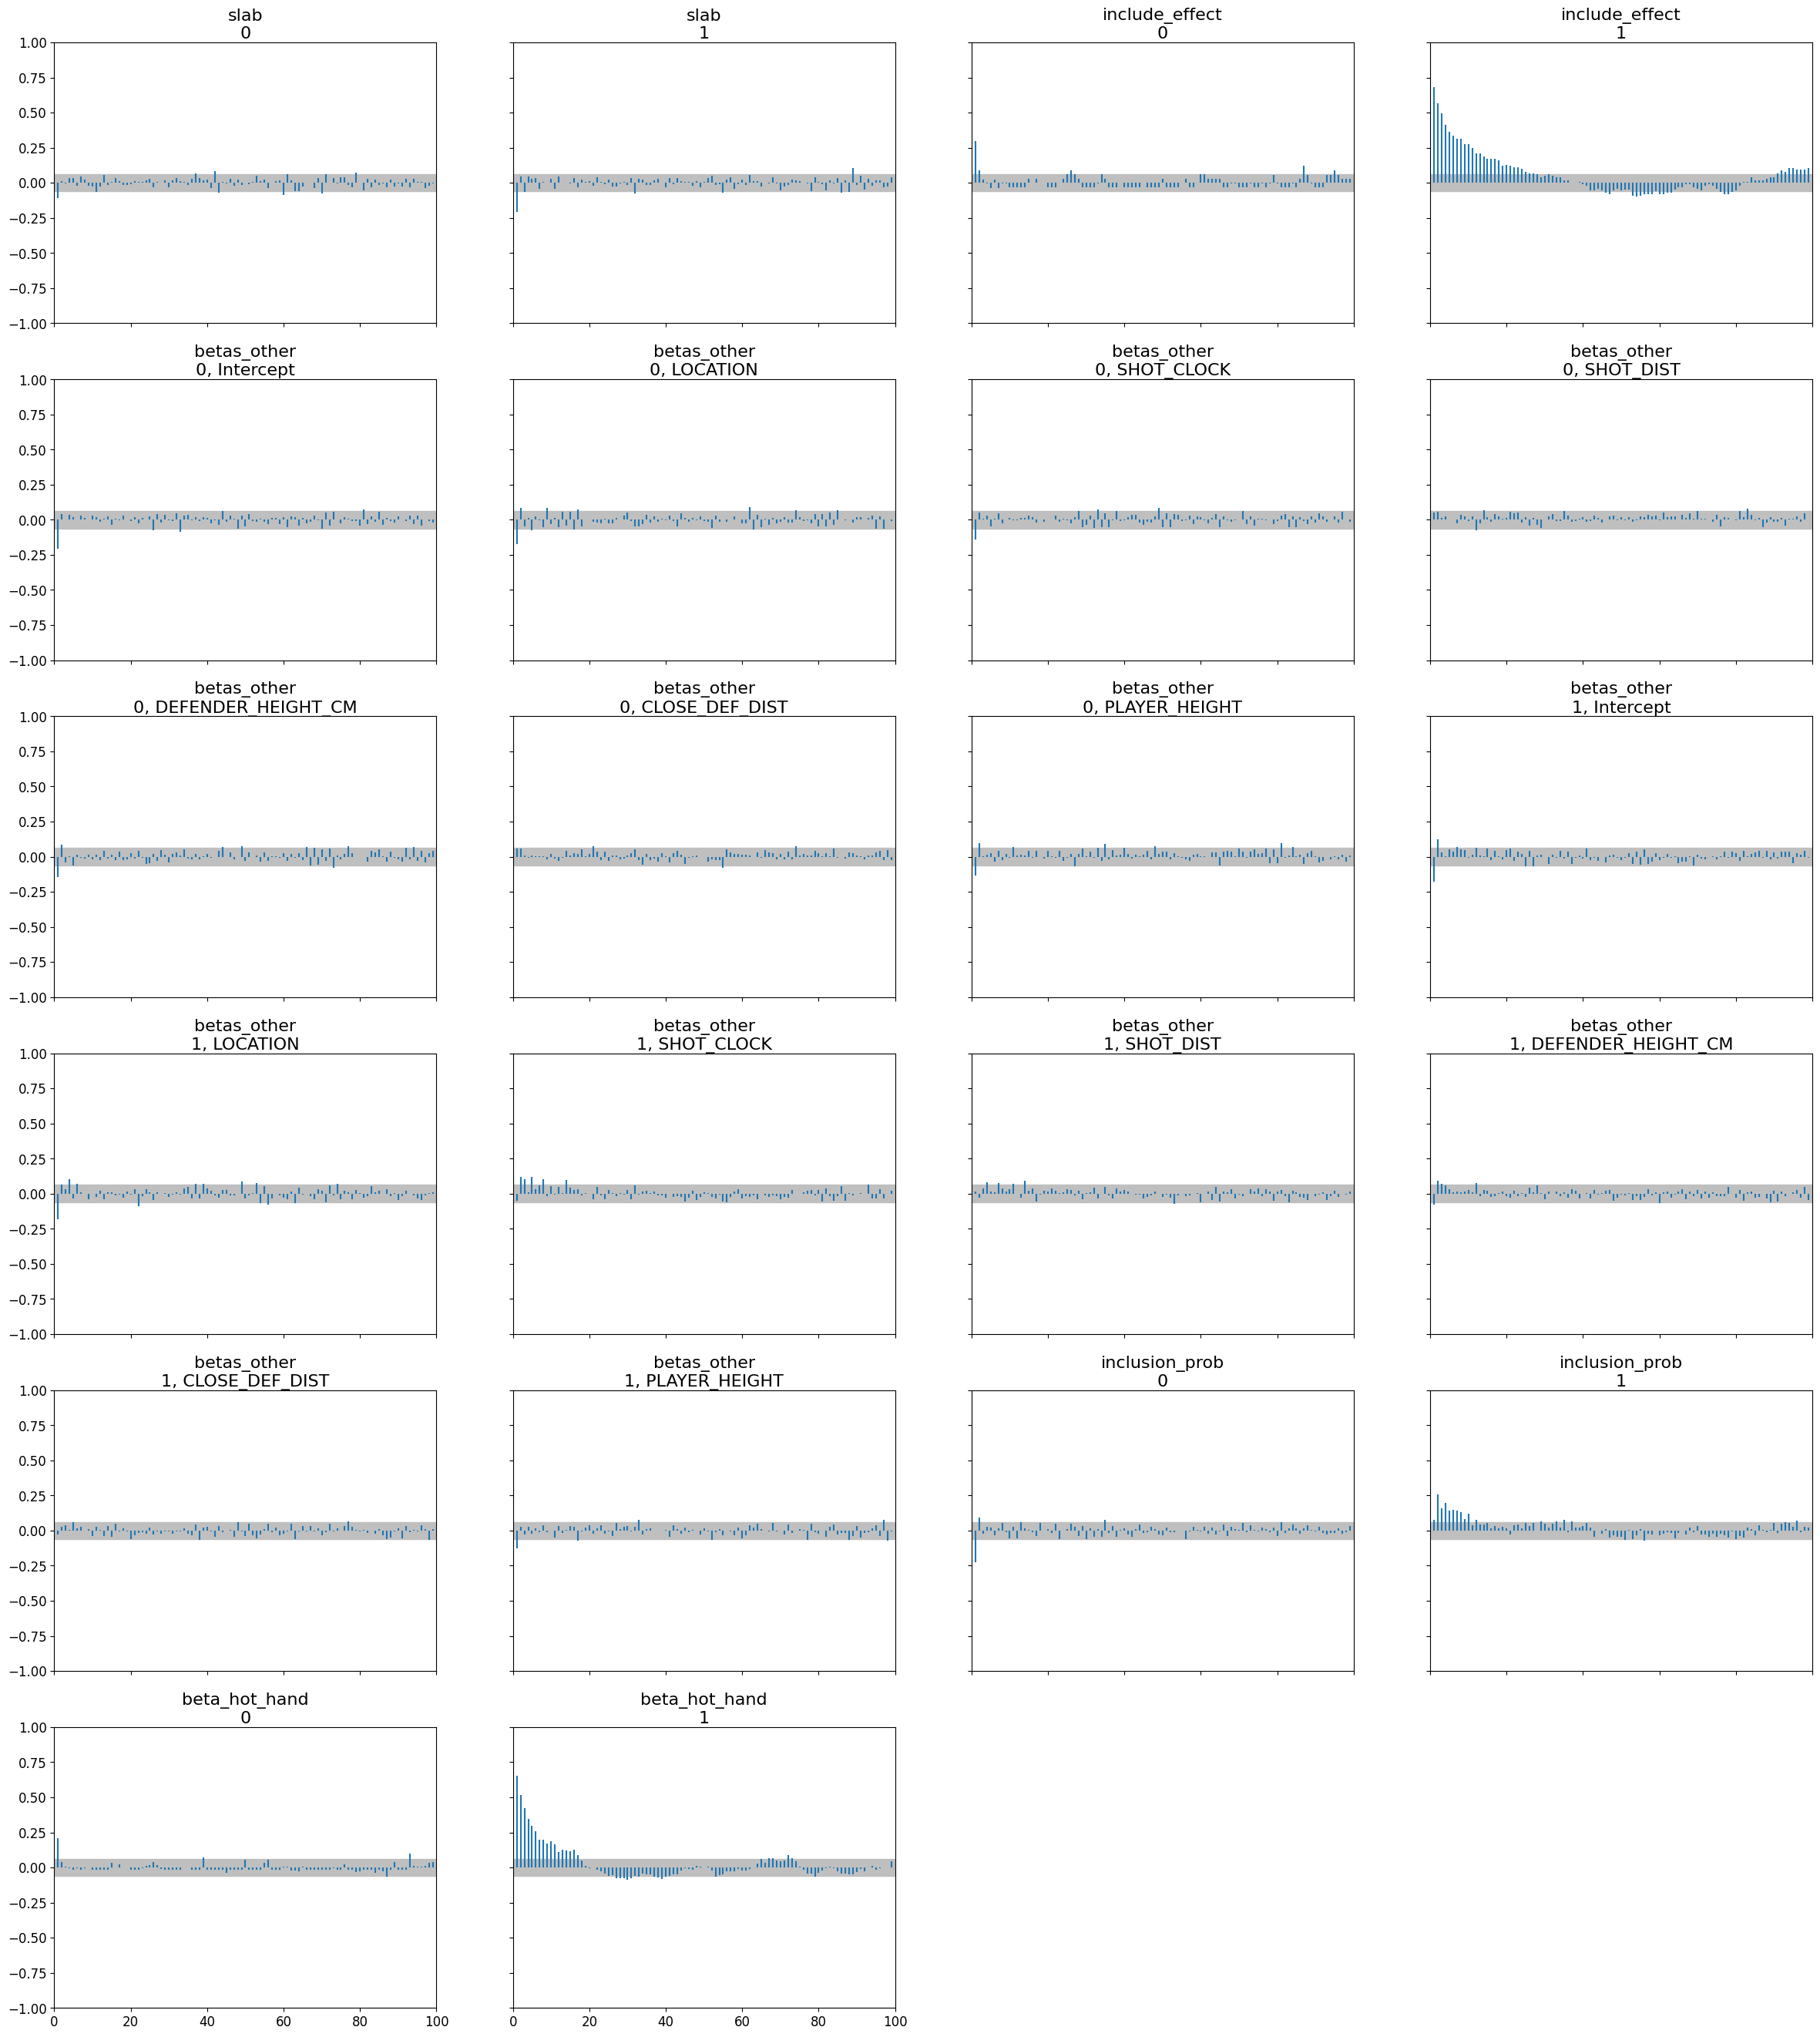

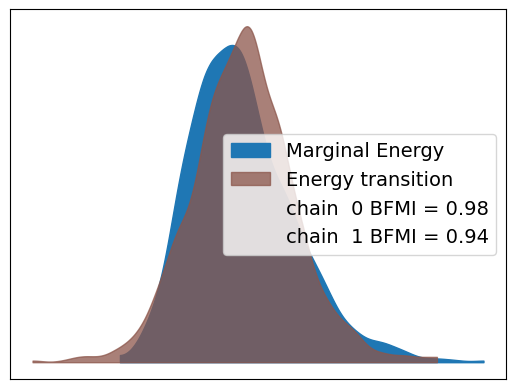

Effective Sample Sizes:
 <xarray.Dataset>
Dimensions:         (cluster: 7)
Coordinates:
  * cluster         (cluster) <U18 'Intercept' 'LOCATION' ... 'PLAYER_HEIGHT'
Data variables:
    slab            float64 2.822e+03
    include_effect  float64 145.3
    betas_other     (cluster) float64 1.59e+03 2.583e+03 ... 1.59e+03 2.175e+03
    inclusion_prob  float64 788.6
    beta_hot_hand   float64 223.6


/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


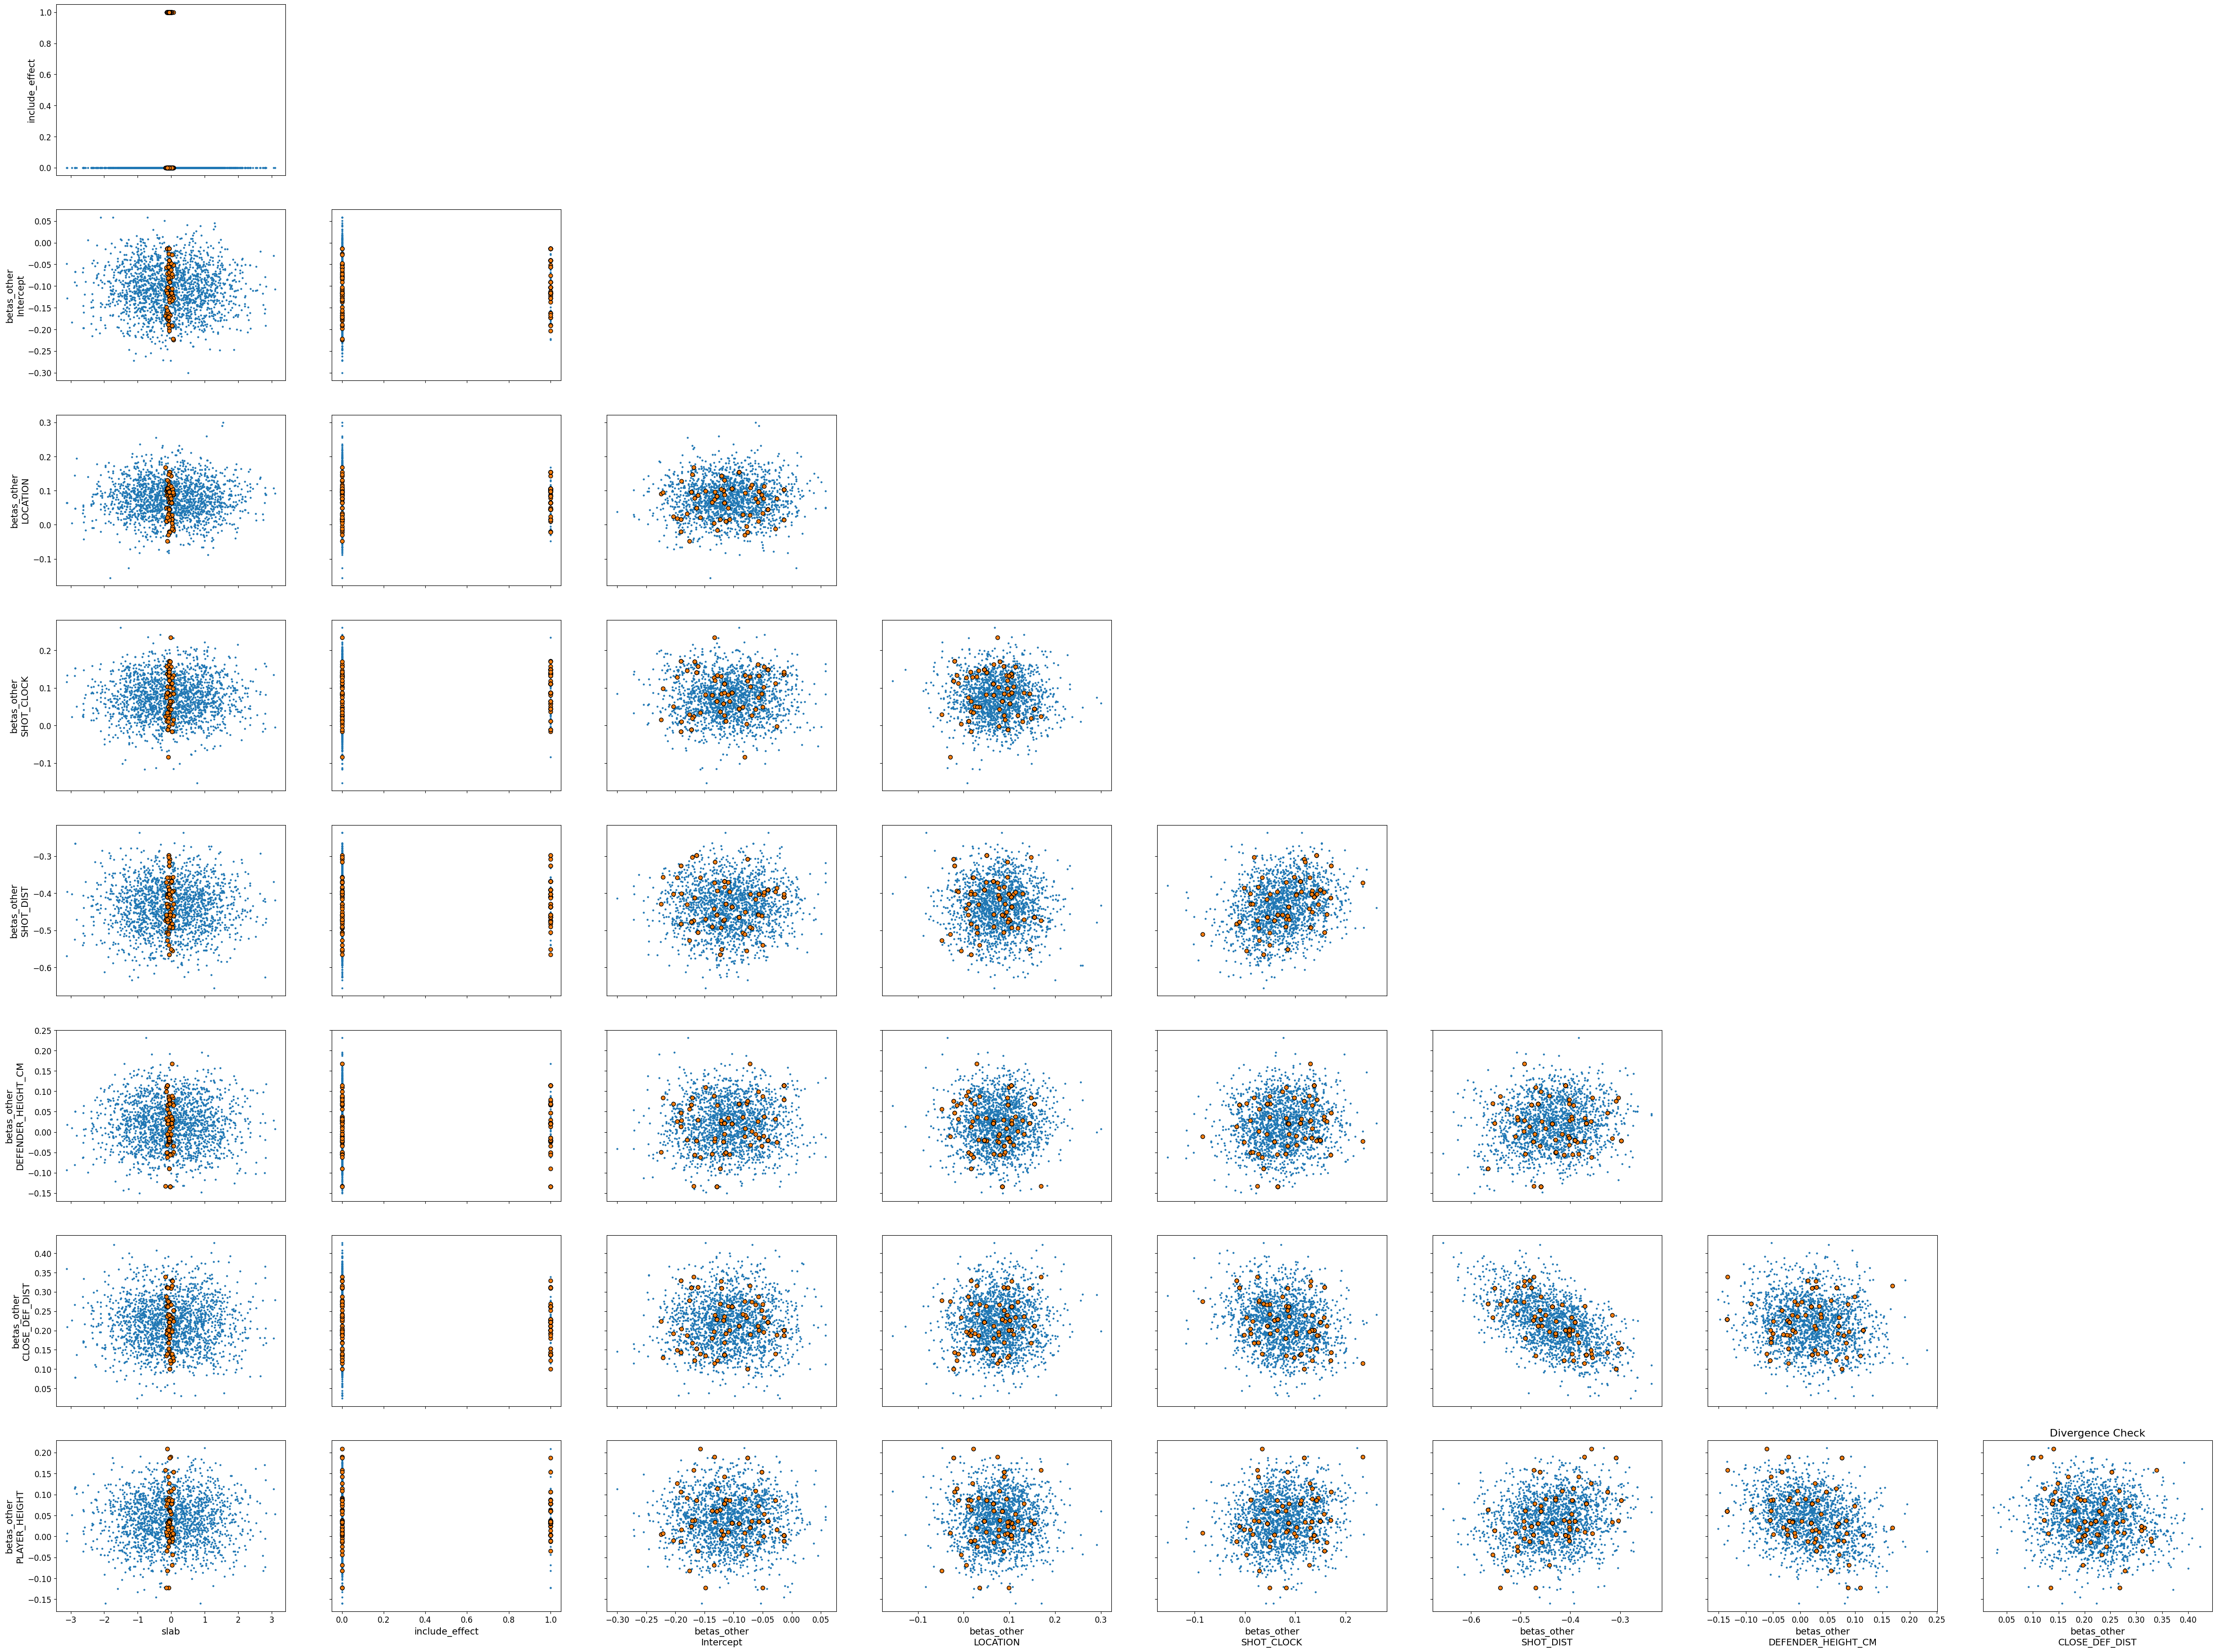

R-hat Diagnostics:
 <xarray.Dataset>
Dimensions:         (cluster: 7)
Coordinates:
  * cluster         (cluster) <U18 'Intercept' 'LOCATION' ... 'PLAYER_HEIGHT'
Data variables:
    slab            float64 1.006
    include_effect  float64 1.018
    betas_other     (cluster) float64 1.002 1.003 1.001 1.002 1.003 1.001 1.007
    inclusion_prob  float64 1.01
    beta_hot_hand   float64 1.018


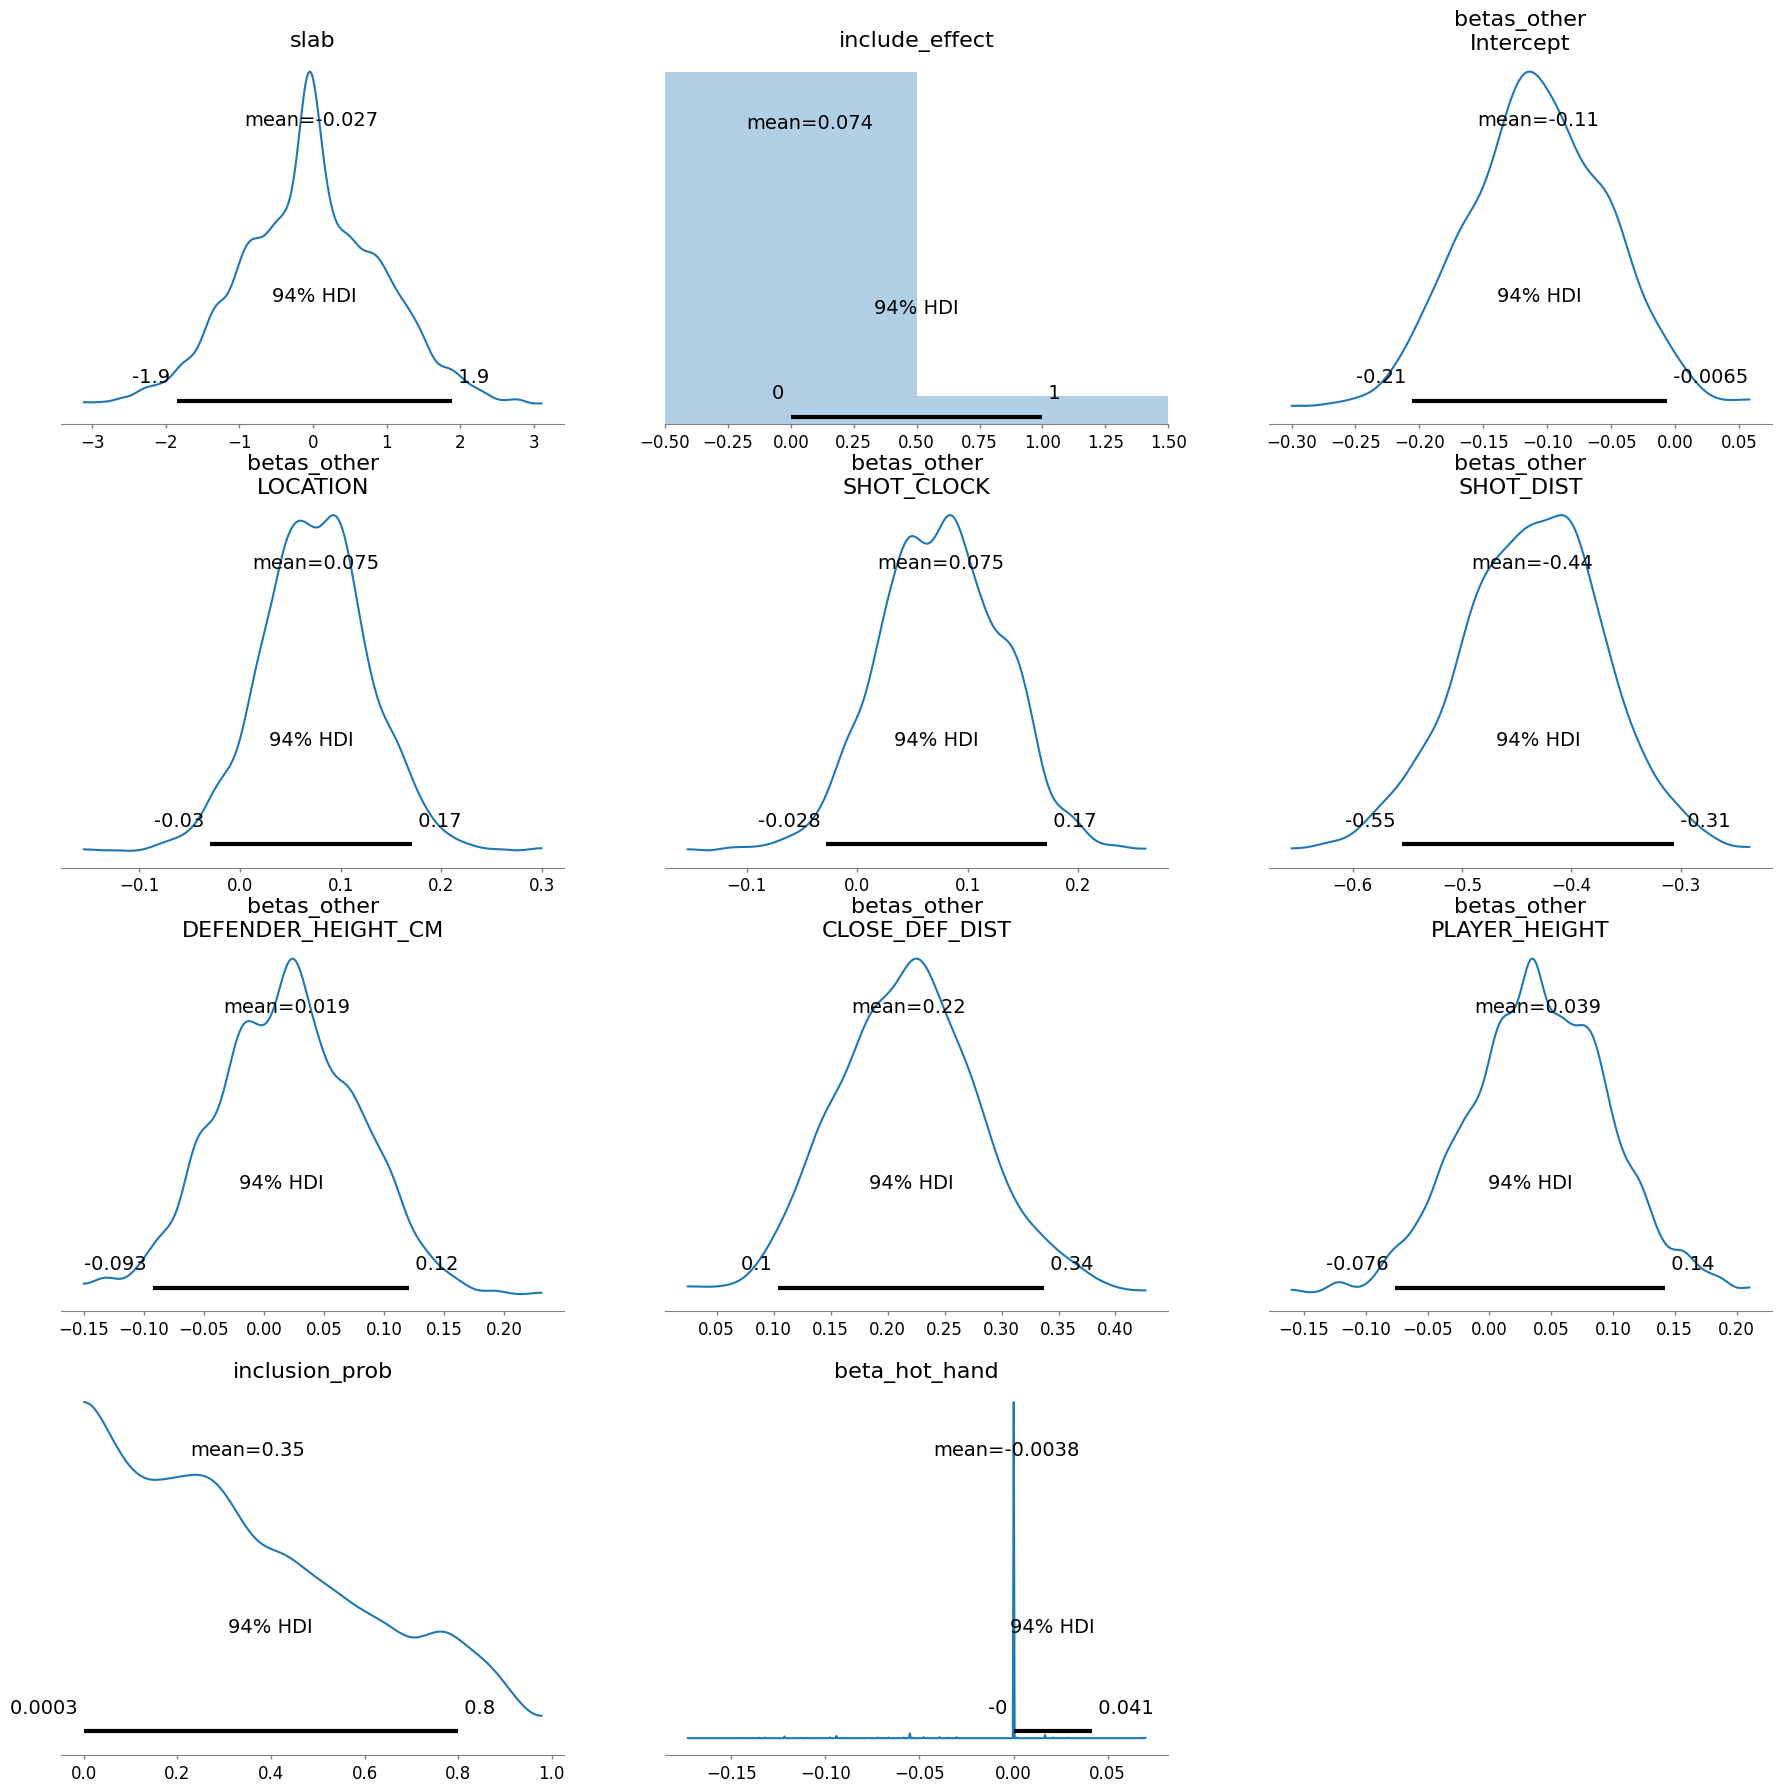

In [21]:
import arviz as az; import matplotlib.pyplot as plt;

print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

import arviz as az
import matplotlib.pyplot as plt

# Assuming idata is the InferenceData object from sampling the model

# Plot trace plots for model parameters to assess convergence
az.plot_trace(idata,compact=False, combined = False);
plt.show()

# Print summary statistics for the posterior distributions
# This will provide you with mean, sd, hdi intervals, etc.
summary_stats = az.summary(idata)
print(summary_stats)

# Plot autocorrelation for each parameter
# This helps to check if the Markov chain has mixed well
az.plot_autocorr(idata)
plt.show()

# Plot energy to check for sampling pathology
az.plot_energy(idata)
plt.show()

# Check effective sample sizes (ess)
# Good ess values suggest that the posterior distribution has been well explored
ess = az.ess(idata)
print("Effective Sample Sizes:\n", ess)

# Check for divergences
# Divergences can indicate problems with the sampling
divergences = az.plot_pair(idata, kind='scatter', divergences=True)
plt.title("Divergence Check")
plt.show()

# Calculate R-hat diagnostics
# Values close to 1.0 suggest that the chain has converged
rhat = az.rhat(idata)
print("R-hat Diagnostics:\n", rhat)

# Optionally, visualize the posterior distributions of parameters
# This gives you a sense of the parameter uncertainty
az.plot_posterior(idata)
plt.show()


For Model 4 we see the Rhat values are indicating the convergence is adequate but looking at the trace plots we see that for many of the betas we would like to have stronger results.

the means of the betas are all bery small except for shot distance and closest defender distance, indicating these are likely the most important predictors when modeling for whether a player will make a shot.

the mean of the inclusion probability is 0.35 meaning that 35% of the time our model will include the hot hand factor when modeling a shot. this would indicate that the hot hand flag is not important when predicting whether a player will make a shot, and thus the hot hand has little affect on a players ability to make a shot.

all other graphs look fine indicating that our model is not grossly misspecified and can serve as a good base for later models.

## Model 5

In [ ]:
#model 5
P2 = X2.shape[1]
col_names = ['Intercept', 'LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT']

# wanted to time code
# start = time.time()

with pm.Model(coords={"cluster": col_names}) as model:
    # Spike-Slab components for the HOT_HAND_SHOT_STREAK3 coefficient
    inclusion_prob = pm.Beta('inclusion_prob', alpha=1, beta=1)
    slab = pm.Normal('slab', mu=0, sigma=1)

    # Binary variable to choose between spike (effect = 0) and slab
    include_effect = pm.Bernoulli('include_effect', p=inclusion_prob)

    # Coefficient for HOT_HAND_SHOT_STREAK3
    # beta_hot_hand = pm.math.switch(include_effect, slab, 0)
    beta_hot_hand = pm.Deterministic("beta_hot_hand", include_effect*slab)


    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 0.75;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=1);
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=P2-1)

    # Coefficients for other predictors, using horsehoe
    #betas_other = pm.Normal('betas_other', mu=0, sigma=1, shape=(P2-1,))
    betas_other = pm.MvNormal('betas_other', mu= np.zeros((P2-1,)), cov= np.eye(P2-1), shape=(P2-1,), dims = 'cluster')

    # Combine all coefficients, assuming HOT_HAND_SHOT_STREAK3 is the last predictor in X2
    # Adjust the concatenation logic if HOT_HAND_SHOT_STREAK3 is in a different position
    betas = pm.math.concatenate([betas_other*weights, [beta_hot_hand]])

    # Calculate the probability of a shot being made
    p_shot_made = pm.math.sigmoid(pm.math.dot(X2, betas))

    # Likelihood of observing the data
    y = pm.Bernoulli('y', p=p_shot_made, observed=y2.flatten())
with model:
    idata = pm.sample(random_seed=1999)
    predictive = pm.sample_posterior_predictive(idata)

Text(0.5, 1.0, 'Posterior Predictive plot')

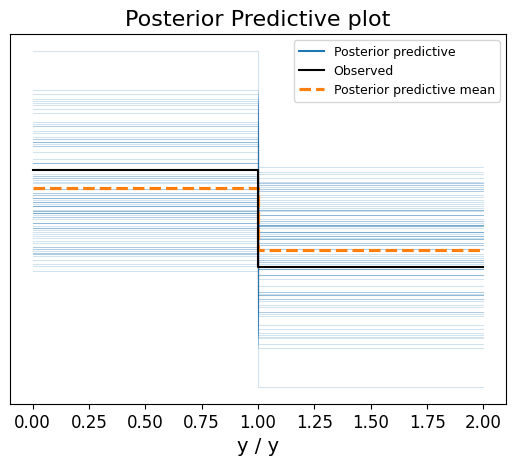

In [ ]:
# Plotting predicted vs. actual outcomes
# mean_preds = np.mean(posterior_preds, axis=0)
# plt.scatter(mean_preds, y2.flatten(), alpha=0.1)
# plt.xlabel('Predicted Probability')
# plt.ylabel('Actual Outcome')
# plt.title('Predicted vs. Actual Outcomes')
# plt.show()
az.plot_ppc(predictive, num_pp_samples=100)
plt.title('Posterior Predictive plot')

The posterior mean is within an acceptable range of the observed values indicating the model has some predictive power.

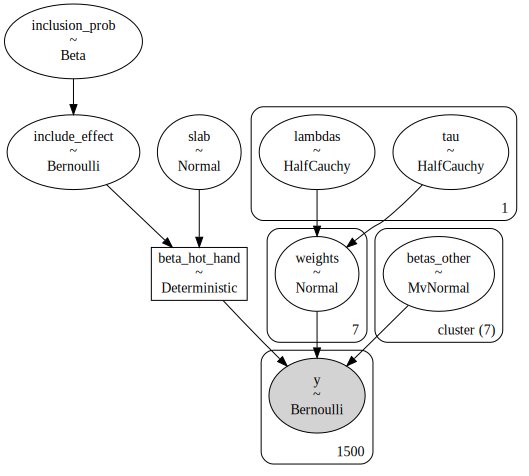

In [ ]:
# Visualization of model graph
pm.model_to_graphviz(model)

HMC Split-Rhats {'slab': 1.002825895, 'include_effect': 0.999983139, 'weights': array([1.01944902, 1.00164811, 1.02240504, 1.02988833, 1.02419466,
       1.02748283, 1.04146498]), 'betas_other': array([1.0121581 , 1.00225689, 1.01007462, 1.0222601 , 1.01259595,
       1.01661172, 1.01382743]), 'inclusion_prob': 1.005999912, 'tau': array([1.00719046]), 'lambdas': array([1.00426092]), 'beta_hot_hand': 1.004123445} | 

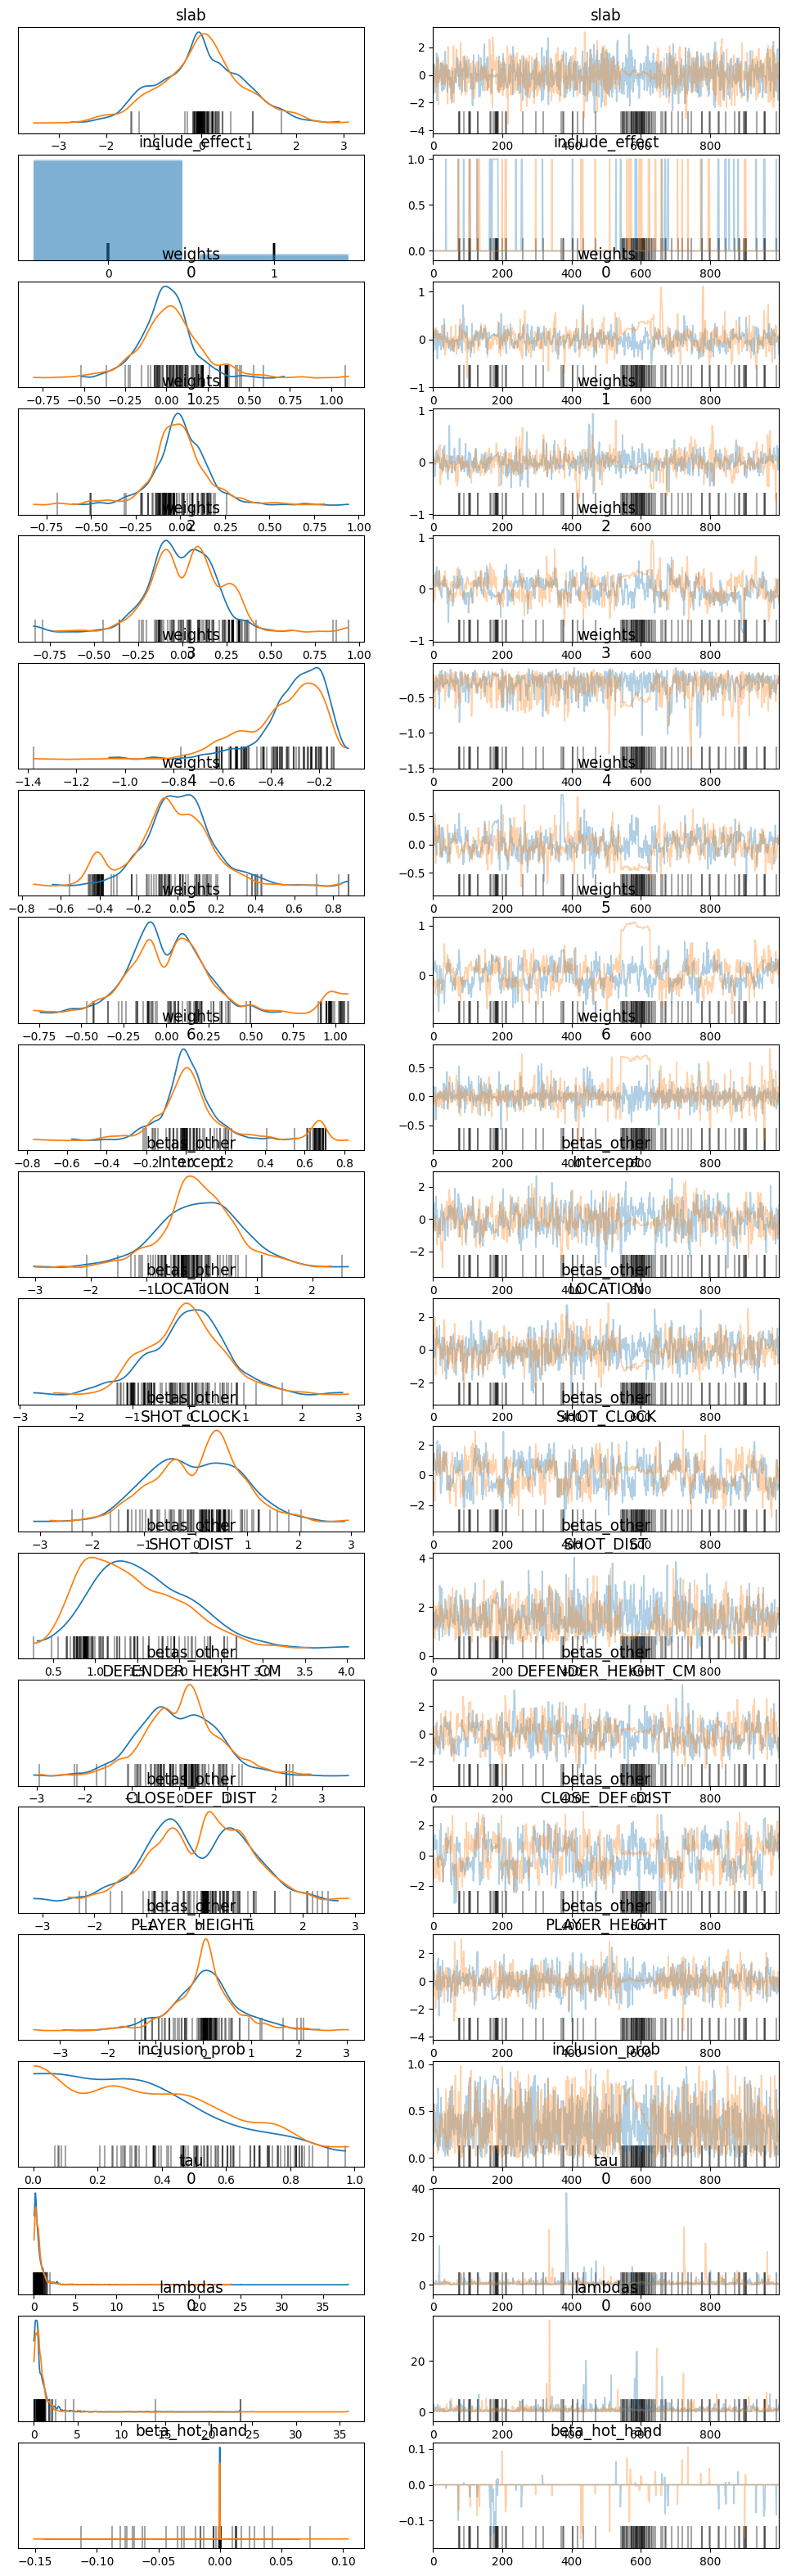

                                  mean     sd  hdi_3%  hdi_97%  mcse_mean  \
slab                            -0.007  0.934  -1.689    1.859      0.022   
include_effect                   0.056  0.230   0.000    0.000      0.011   
weights[0]                       0.014  0.186  -0.326    0.386      0.014   
weights[1]                      -0.000  0.173  -0.313    0.359      0.008   
weights[2]                       0.016  0.201  -0.320    0.366      0.020   
weights[3]                      -0.328  0.156  -0.627   -0.123      0.017   
weights[4]                      -0.009  0.206  -0.451    0.334      0.021   
weights[5]                       0.043  0.293  -0.562    0.525      0.043   
weights[6]                       0.036  0.203  -0.436    0.472      0.033   
betas_other[Intercept]          -0.038  0.739  -1.484    1.402      0.032   
betas_other[LOCATION]           -0.035  0.717  -1.544    1.170      0.041   
betas_other[SHOT_CLOCK]          0.020  0.867  -1.582    1.540      0.059   

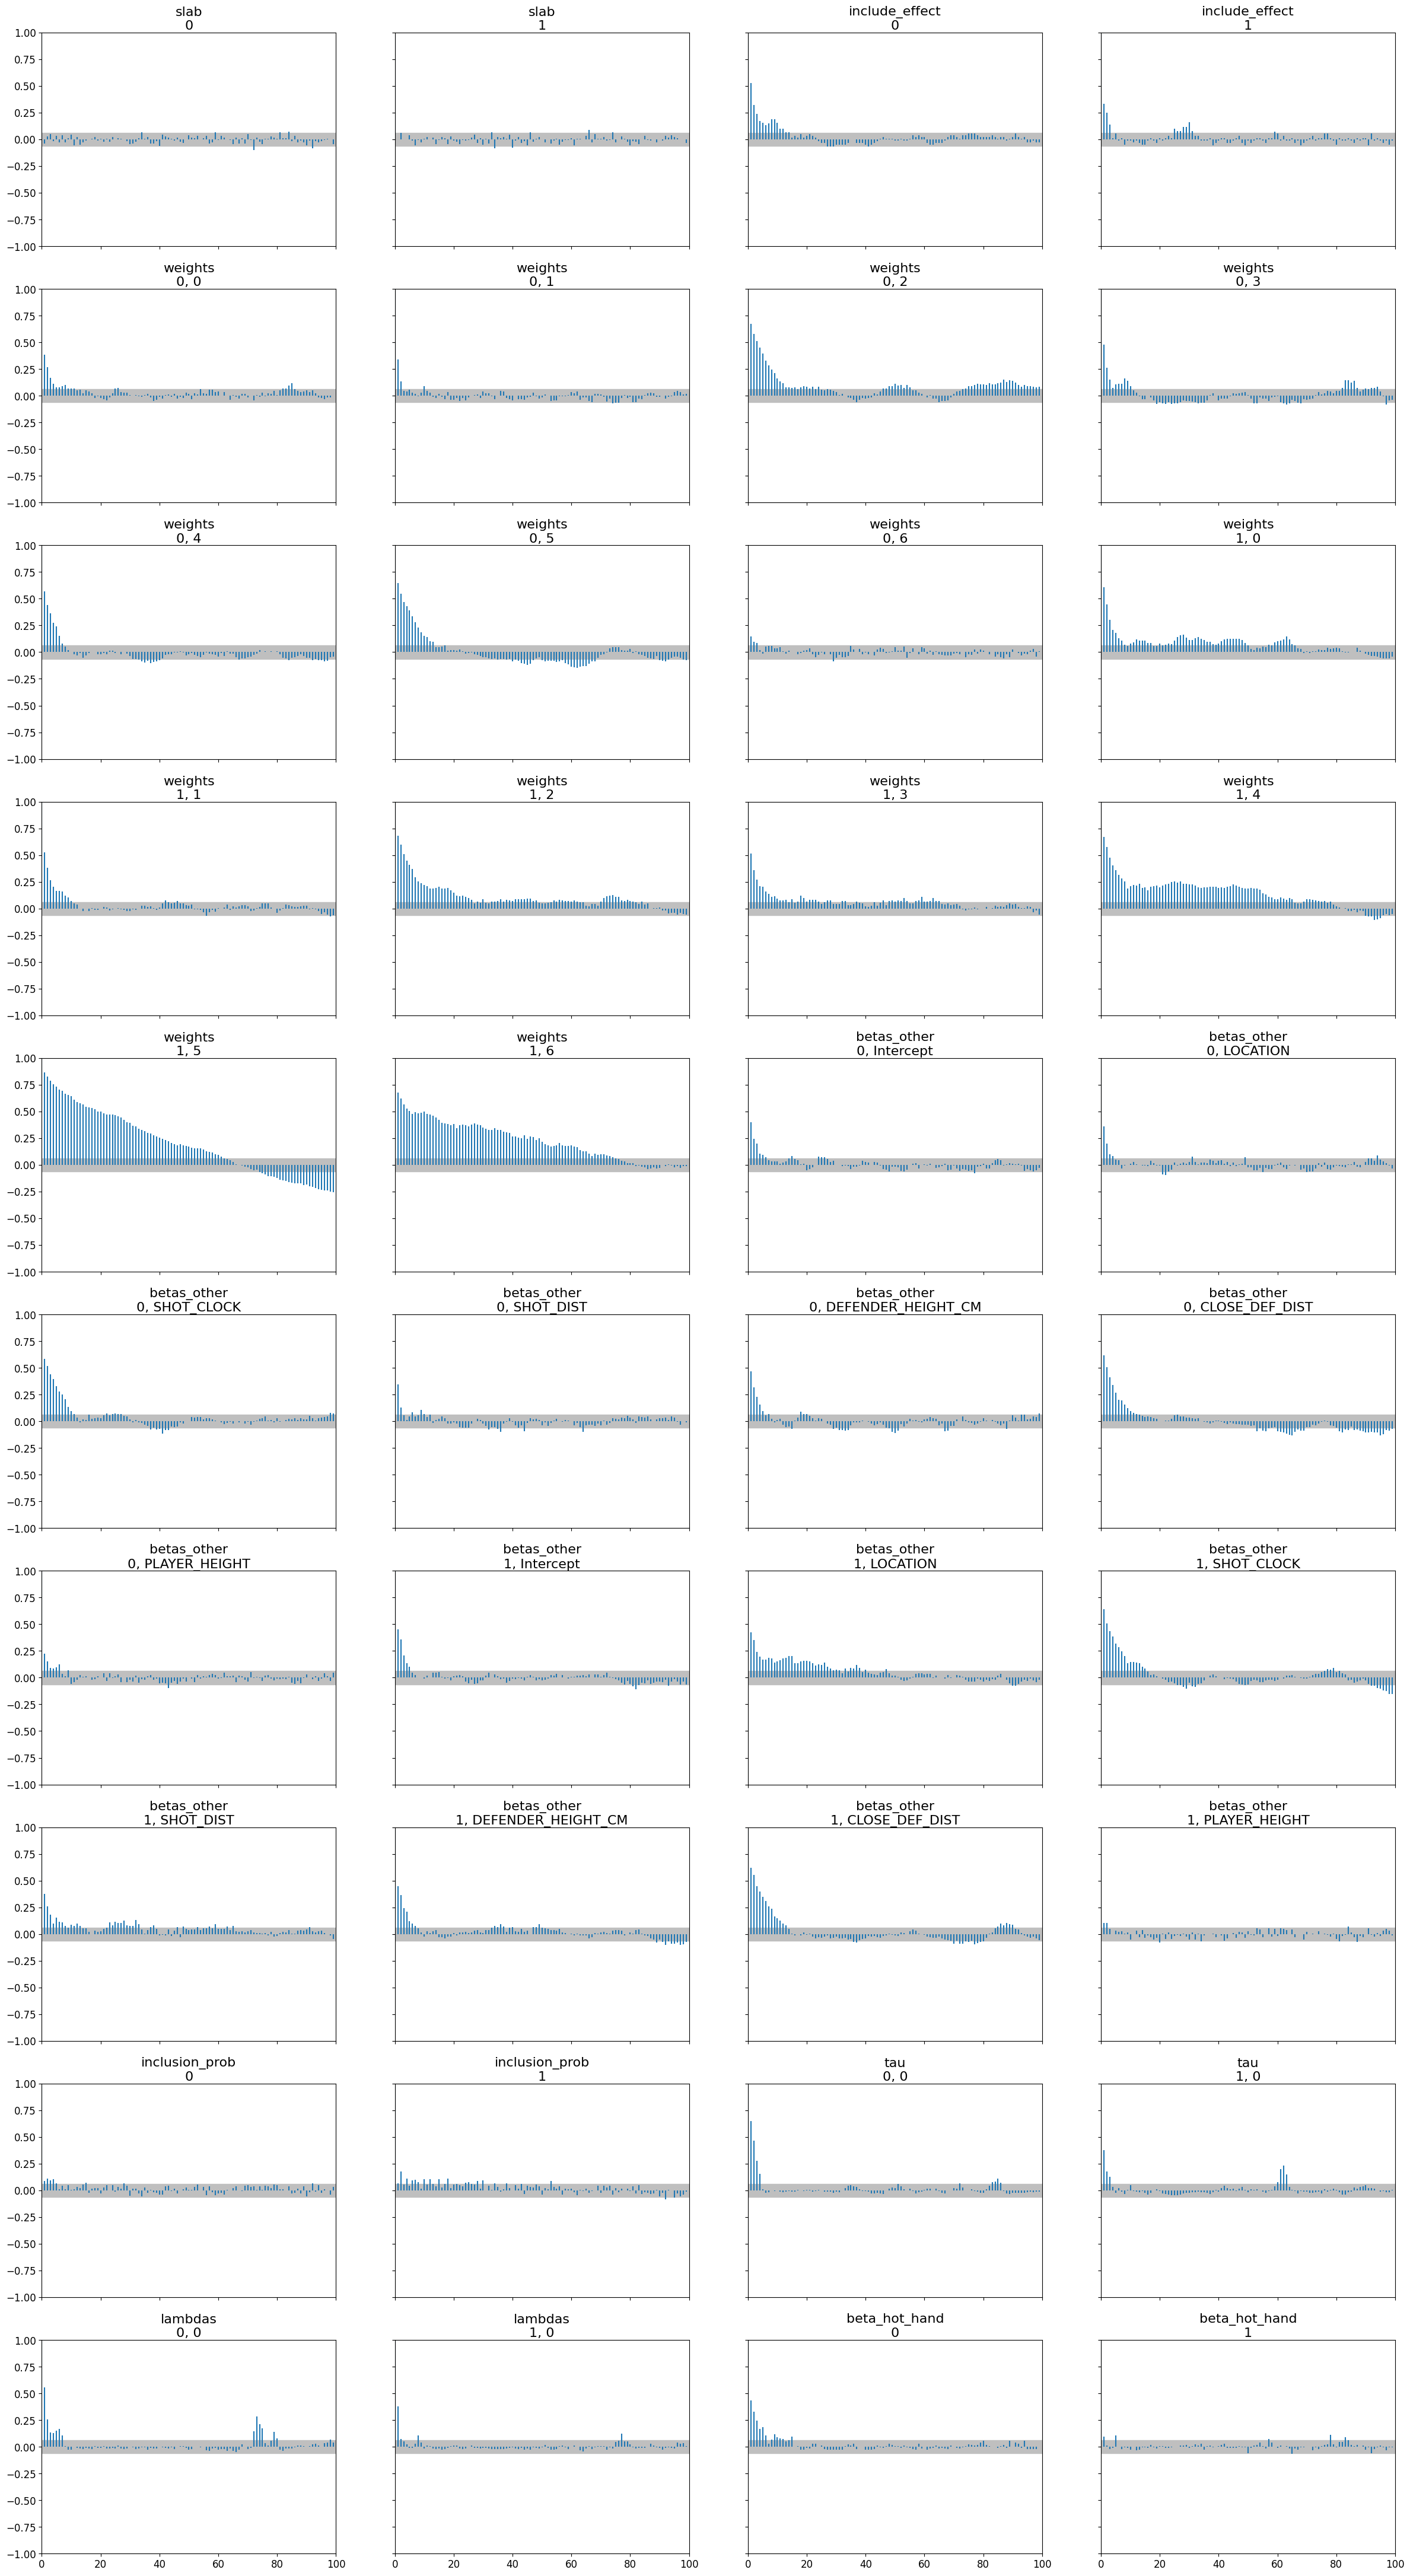

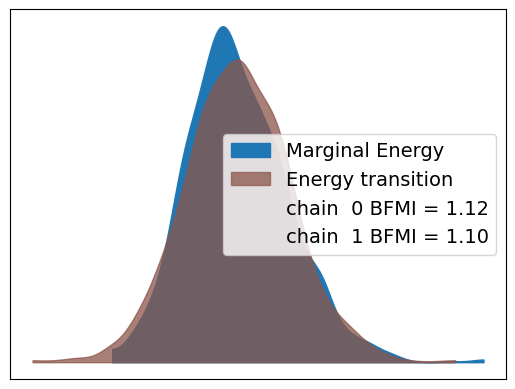

Effective Sample Sizes:
 <xarray.Dataset>
Dimensions:         (weights_dim_0: 7, cluster: 7, tau_dim_0: 1,
                     lambdas_dim_0: 1)
Coordinates:
  * weights_dim_0   (weights_dim_0) int64 0 1 2 3 4 5 6
  * cluster         (cluster) <U18 'Intercept' 'LOCATION' ... 'PLAYER_HEIGHT'
  * tau_dim_0       (tau_dim_0) int64 0
  * lambdas_dim_0   (lambdas_dim_0) int64 0
Data variables:
    slab            float64 1.731e+03
    include_effect  float64 463.3
    weights         (weights_dim_0) float64 189.9 461.9 107.0 ... 97.87 105.3
    betas_other     (cluster) float64 512.1 295.0 228.3 230.6 472.5 256.9 901.9
    inclusion_prob  float64 601.2
    tau             (tau_dim_0) float64 708.1
    lambdas         (lambdas_dim_0) float64 776.9
    beta_hot_hand   float64 880.0


/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


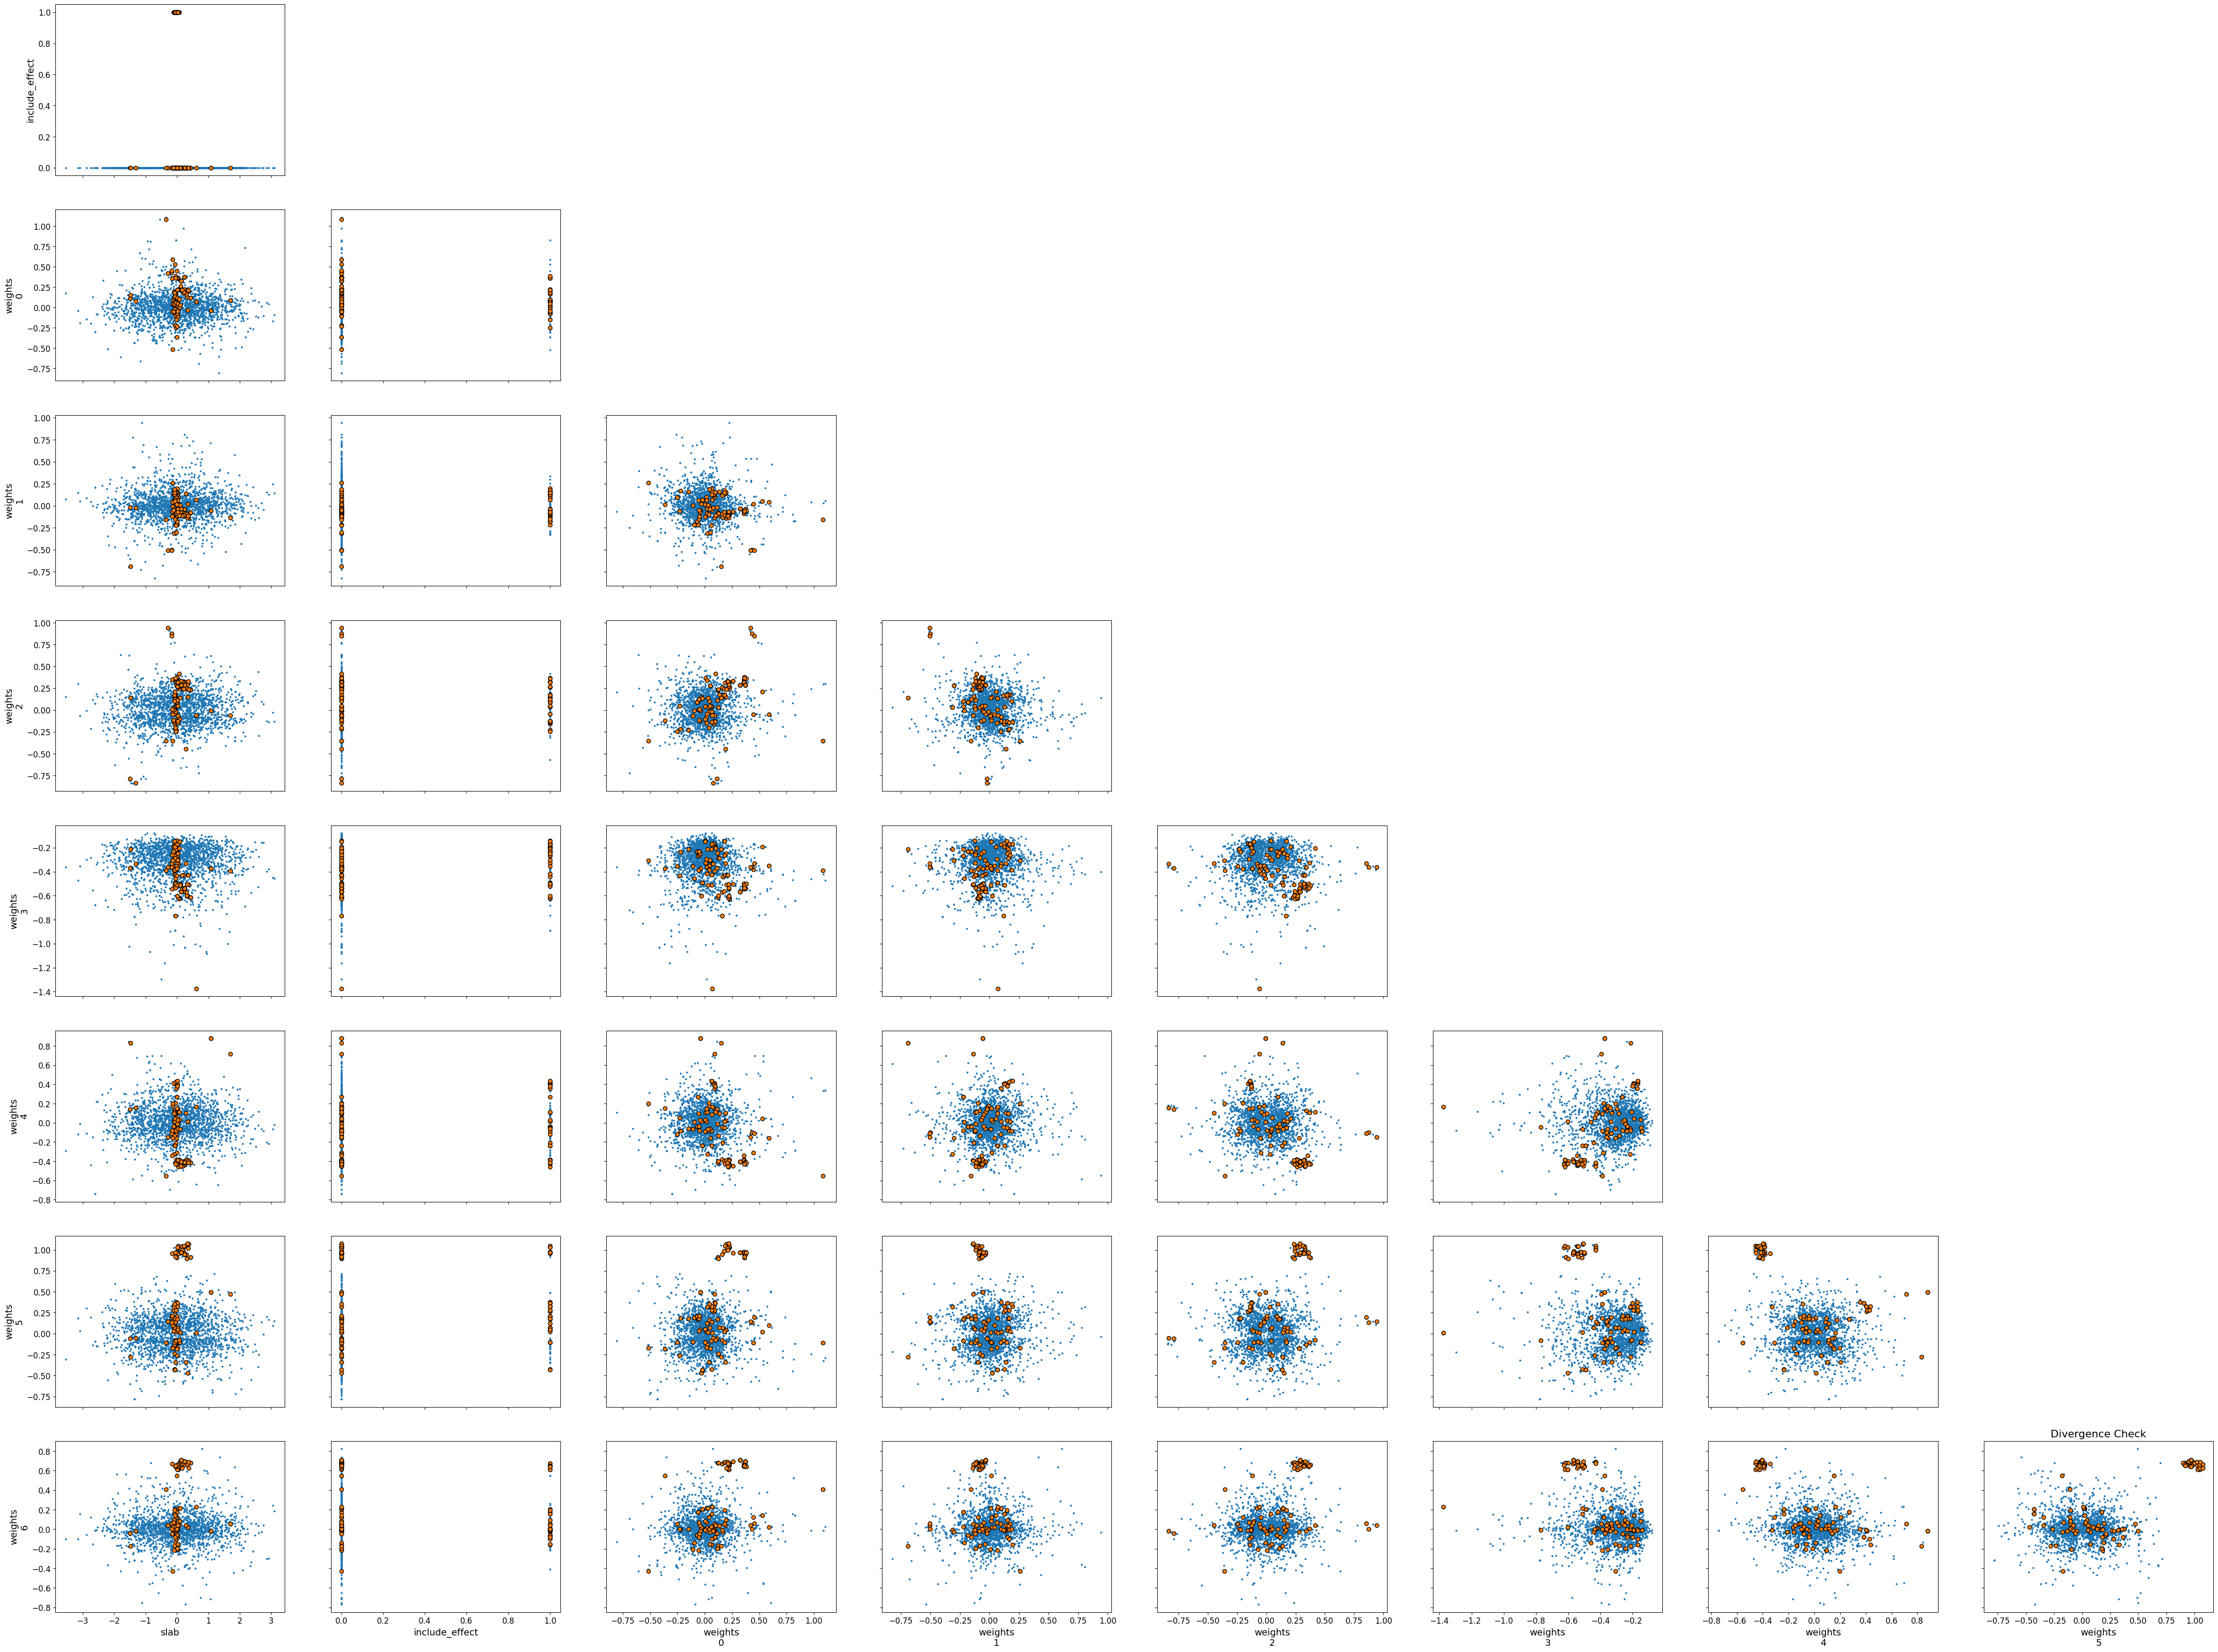

R-hat Diagnostics:
 <xarray.Dataset>
Dimensions:         (weights_dim_0: 7, cluster: 7, tau_dim_0: 1,
                     lambdas_dim_0: 1)
Coordinates:
  * weights_dim_0   (weights_dim_0) int64 0 1 2 3 4 5 6
  * cluster         (cluster) <U18 'Intercept' 'LOCATION' ... 'PLAYER_HEIGHT'
  * tau_dim_0       (tau_dim_0) int64 0
  * lambdas_dim_0   (lambdas_dim_0) int64 0
Data variables:
    slab            float64 1.003
    include_effect  float64 1.0
    weights         (weights_dim_0) float64 1.019 1.002 1.022 ... 1.027 1.041
    betas_other     (cluster) float64 1.012 1.002 1.01 1.022 1.013 1.017 1.014
    inclusion_prob  float64 1.006
    tau             (tau_dim_0) float64 1.007
    lambdas         (lambdas_dim_0) float64 1.004
    beta_hot_hand   float64 1.004


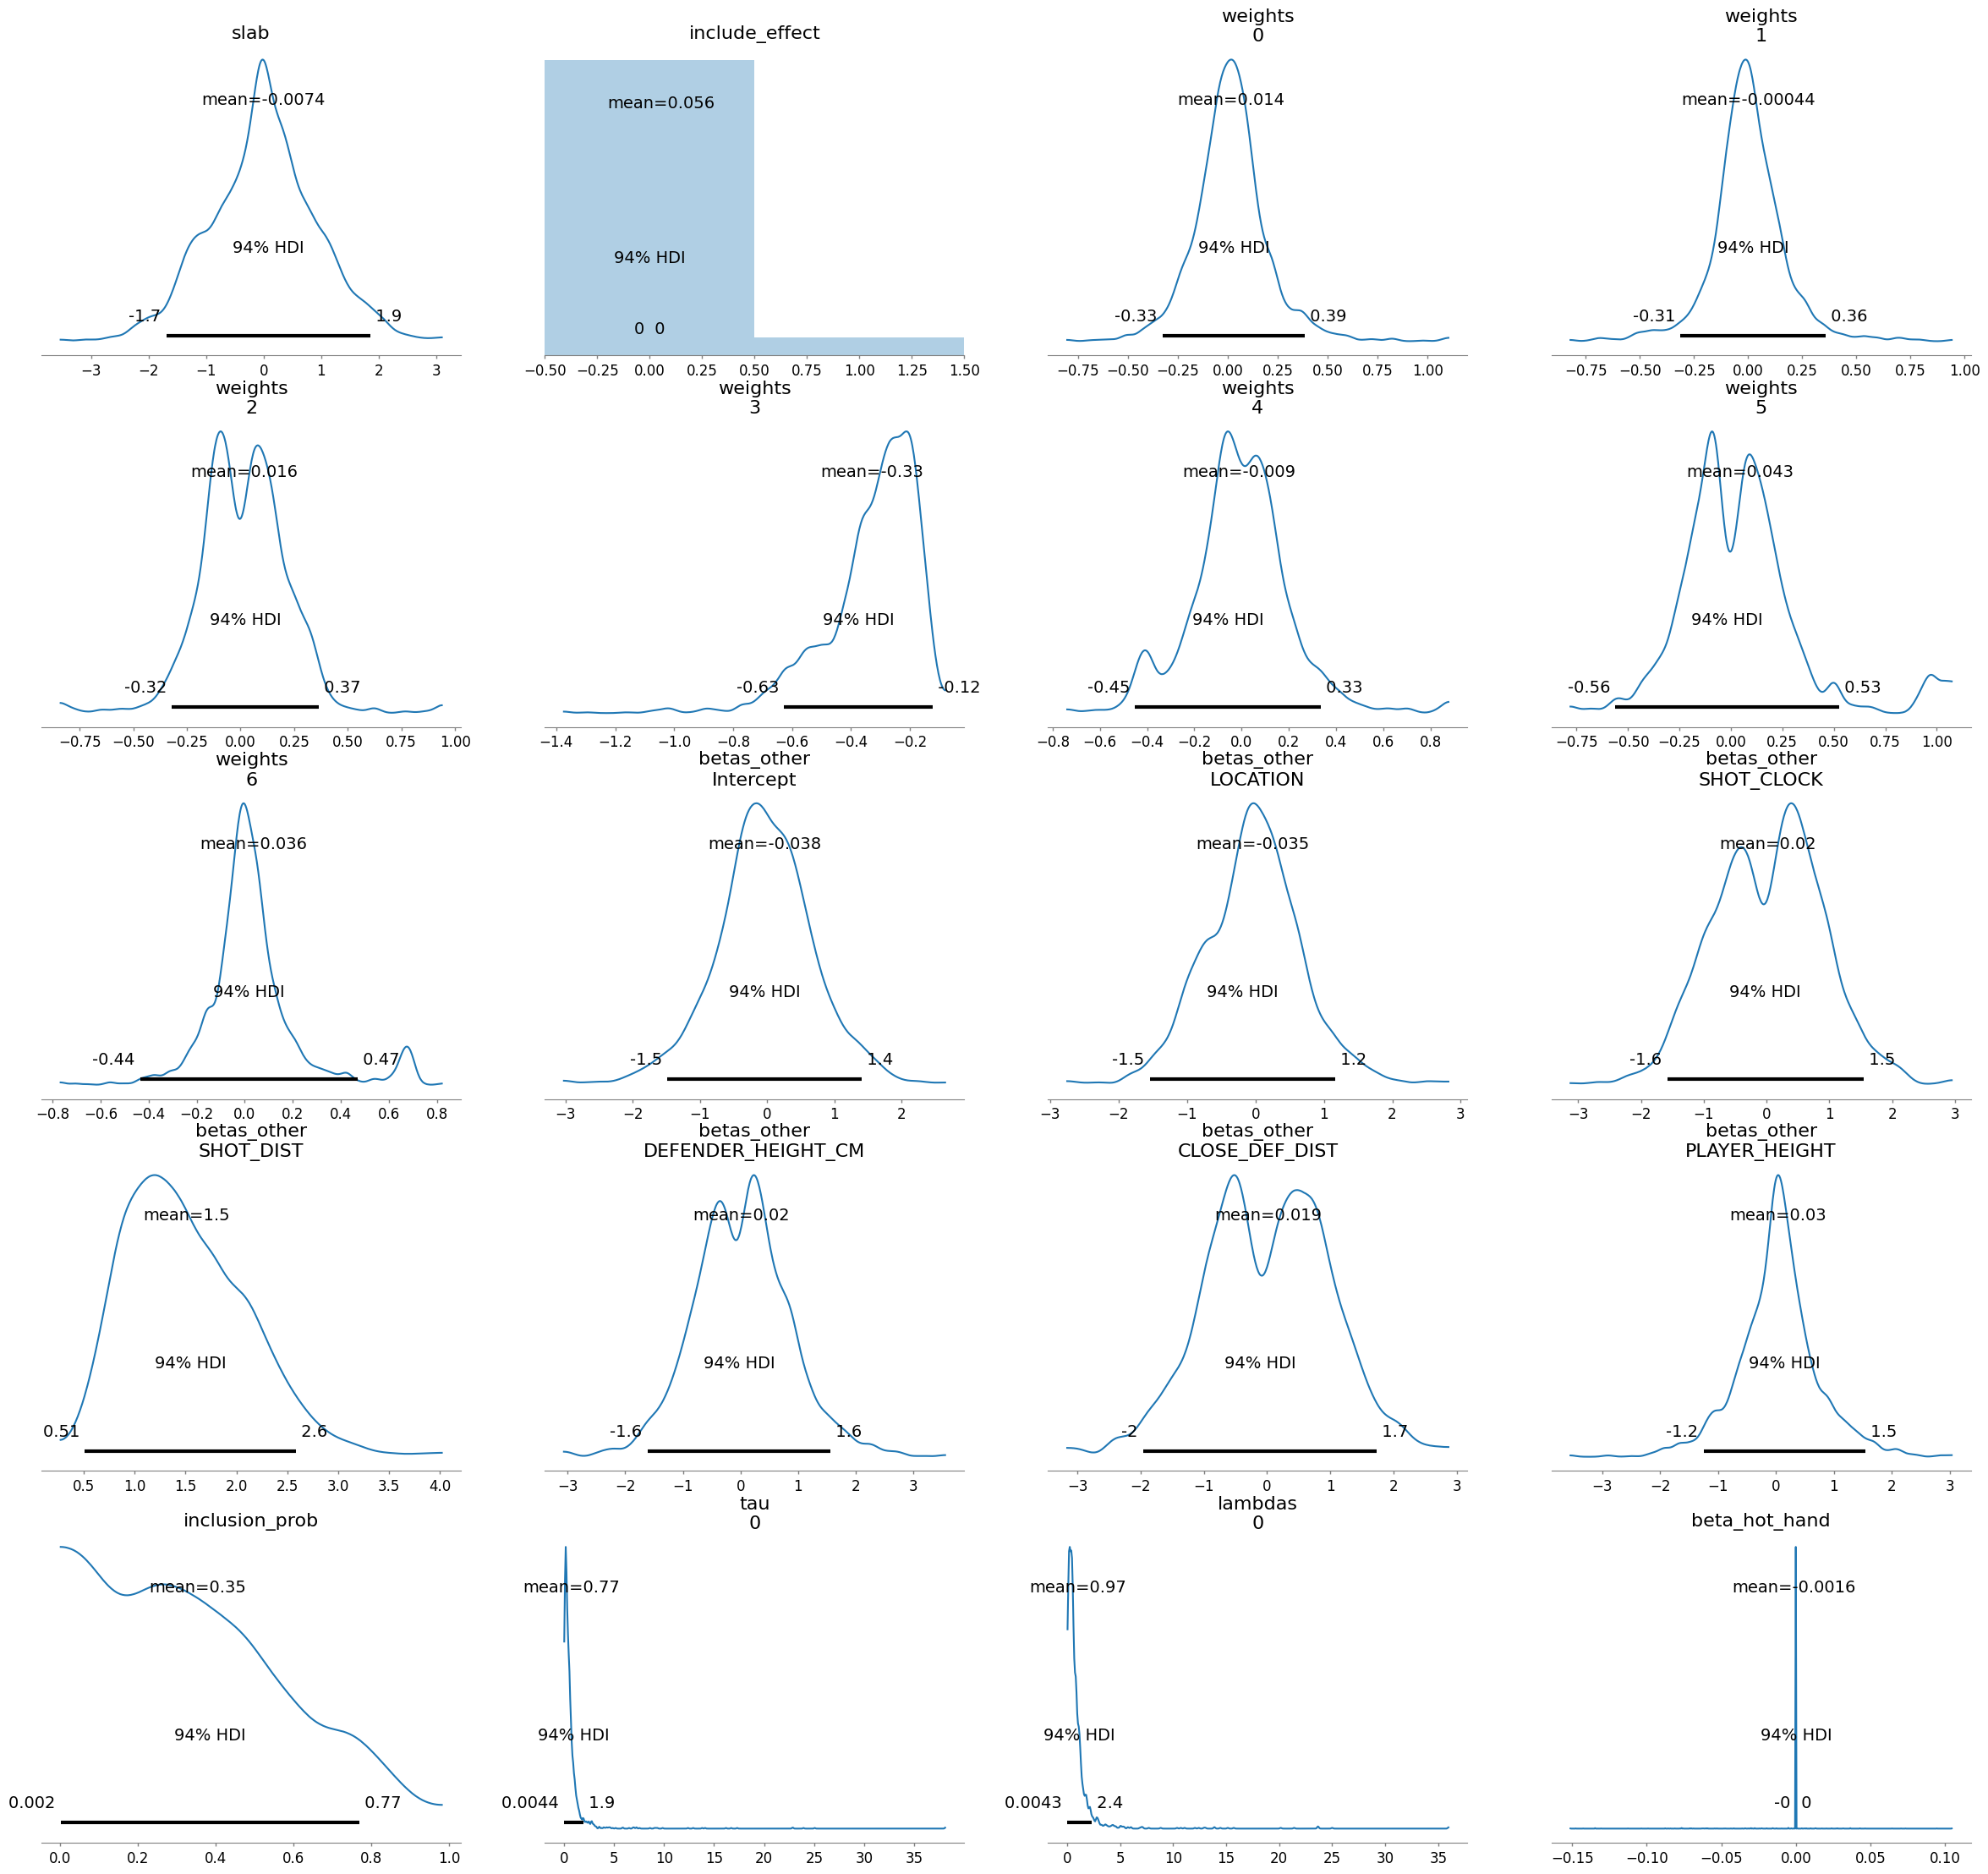

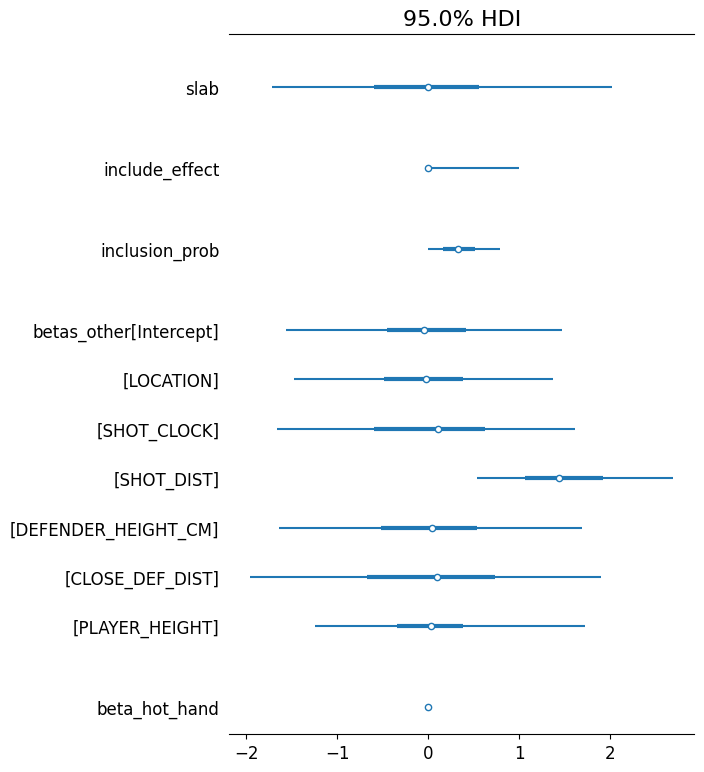

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;

print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

import arviz as az
import matplotlib.pyplot as plt

# Assuming idata is the InferenceData object from sampling the model

# Plot trace plots for model parameters to assess convergence
az.plot_trace(idata,compact=False, combined = False);
plt.show()

# Print summary statistics for the posterior distributions
# This will provide you with mean, sd, hdi intervals, etc.
summary_stats = az.summary(idata)
print(summary_stats)

# Plot autocorrelation for each parameter
# This helps to check if the Markov chain has mixed well
az.plot_autocorr(idata)
plt.show()

# Plot energy to check for sampling pathology
az.plot_energy(idata)
plt.show()

# Check effective sample sizes (ess)
# Good ess values suggest that the posterior distribution has been well explored
ess = az.ess(idata)
print("Effective Sample Sizes:\n", ess)

# Check for divergences
# Divergences can indicate problems with the sampling
divergences = az.plot_pair(idata, kind='scatter', divergences=True)
plt.title("Divergence Check")
plt.show()

# Calculate R-hat diagnostics
# Values close to 1.0 suggest that the chain has converged
rhat = az.rhat(idata)
print("R-hat Diagnostics:\n", rhat)

# Optionally, visualize the posterior distributions of parameters
# This gives you a sense of the parameter uncertainty
az.plot_posterior(idata)
plt.show()

# Forest plots
az.plot_forest(idata, var_names=['slab', 'include_effect', 'inclusion_prob', 'betas_other', 'beta_hot_hand'], combined=True, hdi_prob=0.95)
plt.show()

the rhat values are all less than 1.05 which is a good indication for our model, the trace plots could be better but especially for the betas we are happy with the results as they follow a similar shape, just need to be a bit tigher together.

interestingly model 5 indicates the only meaningful predictor is the shot distance. it has said that the mean of the betas are relativly close together meaning that all the other predictors have roughtly the same amount of impact, which is much different from model 4 where only a few predictors has larger means and thus were more important in prediction.

our sample size is large enough to meet the nessesary sample size for all the parameters.

the energy graphs are slightly better differening less than in model 4.

the posterior distributions are to be expected, except some of them have bimodal patterns, in the future a mixed distribution could be useful for these specific predictor values.

the betas being centred around 0 for the most part makes sense as the data is standardised and thus indicates that alot of our data is based around the mean.

the mean of the inclusion probability is slightly better but not significantly larger than what we had in model 4. thus the inclusion of the horshoe prior on our betas has helped our model checks but has done little to improve the effect of the hot hand flag. we consider this further evidence that the hot hand fallacy is just that, a fallacy with not statistical truth.

# **6. The Final Model**

Based on the analysis done on the 5 models above and the discussions made based on the diagnostic charts, we have decided that model 5 is our final model and provides the most predictive power. thus based off our posterior inferences, we determine that the hot hand flag has very little effect on a players ability to hit a shot and thus we believe the notion that a player on a hot streak will be more likely to hit shots is a false belief.

# **7. Conclusion**

our verdict on the "fallacy" and interpreting the results from previous section

# **8. Limitations**

We provide a list of limitations and further considerations for our model.

Dependence of outcomes:
We attempted to account for the sequential dependence in the outcomes by adding an indicator variable for streaks of shots made. However, this may not fully account for dependence between outcome. This means that it may not be appropriate to use a generalized linear model. A more appropriate model is a two state Hidden Markov Model.

Definition of a "hot hand":
Our current definition of a "hot hand" is making three consecutive shots in a row. Other definitions of a "hot hand" could be considered e.g. a quarter where the player's fg% is significantly higher than usual.

Consider other predictors:
Some examples of predictors we could consider are field goal% of the season, different types of field goals, opponent defensive rating, and team defensive rating.

Subset of playerbase:
This model investigated the impact of the "hot hand" on star players. A further investigation could investigate the impact of the "hot hand" on average NBA players.
